In [1]:
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np 
import os
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
from torch.utils.data import Dataset
from torchvision.io import read_image
from PIL import Image

import gc

import torchvision.models as models
from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import copy
import glob
from torchvision.transforms import functional
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


### ResNet18

In [3]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [5]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Encoder(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(Encoder, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder,self).__init__()
        self.dfc3 = nn.Linear(latent_size, 4096)
        self.bn3 = nn.BatchNorm1d(4096)
        self.dfc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)
        self.dfc1 = nn.Linear(4096,256 * 6 * 6)
        self.bn1 = nn.BatchNorm1d(256*6*6)
        self.upsample1=nn.Upsample(scale_factor=2)
        self.dconv5 = nn.ConvTranspose2d(256, 256, 3, padding = 0)
        self.dconv4 = nn.ConvTranspose2d(256, 384, 3, padding = 1)
        self.dconv3 = nn.ConvTranspose2d(384, 192, 3, padding = 1)
        self.dconv2 = nn.ConvTranspose2d(192, 64, 5, padding = 2)
        self.dconv1 = nn.ConvTranspose2d(64, 3, 12, stride = 4, padding = 4)
    

    def forward(self,x):#,i1,i2,i3):
        x = self.dfc3(x)
        x = F.relu(self.bn3(x))
        x = self.dfc2(x)
        x = F.relu(self.bn2(x))
        x = self.dfc1(x)
        x = F.relu(self.bn1(x))
        x = x.view(-1,256,6,6)
        x=self.upsample1(x)
        x = self.dconv5(x)
        x = F.relu(x)
        x = F.relu(self.dconv4(x))
        x = F.relu(self.dconv3(x))
        x=self.upsample1(x)
        x = self.dconv2(x)
        x = F.relu(x)
        x=self.upsample1(x)
        x = self.dconv1(x)
        x = F.sigmoid(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, latent_size):
        super(Autoencoder,self).__init__()
        self.encoder = encoder
        self.decoder = Decoder(latent_size)

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Classifier(nn.Module):
    def __init__(self, latent_size, num_class):
        super(Classifier, self).__init__()
        self.L1 = nn.Linear(latent_size, 256)
        self.L2 = nn.Linear(256, 32)
        self.L3 = nn.Linear(32, num_class)

    def forward(self,x):
        x = self.L1(x)
        x = F.relu(x)
        x = self.L2(x)
        x = F.relu(x)
        x = self.L3(x) 
        return x

class Classification(nn.Module):
	def __init__(self, encoder, latent_size, num_class):
		super(Classification,self).__init__()
		self.encoder = encoder
		self.classifier = Classifier(latent_size, num_class)

	def forward(self,x):
		x= self.encoder(x)
		x = self.classifier(x)
		return x

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

### Vanilla Classifier (with no additional information)

In [7]:
class VanillaClassifier():
    def __init__(self, model_name, train_path, test_path=None):
        self.model_name = model_name
        self.batch_size = 64
        self.latent_size = 1000
        self.num_class = 5
        self.learning_rate = 1e-4
        self.num_epochs = 20
        self.transform = transforms.Compose(
            	[
                transforms.Resize((400,400)),
                transforms.CenterCrop((224,224)),
                transforms.ColorJitter(brightness=.7, hue=.3),
                transforms.RandomAffine(degrees=(-10, 10), translate=(0,0.2), scale=(0.8,1.2), shear=(-20,20)),
                transforms.RandomRotation(degrees=(0, 180)),
            	transforms.ToTensor(),
            	transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
            )
        self.transform_test = transforms.Compose([transforms.Resize((400,400)),
                                    transforms.CenterCrop((224,224)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        self.train_path = train_path
        self.test_path = test_path
        
        if self.test_path != None: 
            # "../cs5242_project_dataset/WBC_100/train/data"
            self.trainset=torchvision.datasets.ImageFolder(self.train_path, transform=self.transform, target_transform=None)
            self.train_loader = torch.utils.data.DataLoader(self.trainset, shuffle = True , batch_size = self.batch_size , num_workers = 2)
            
            self.testset=torchvision.datasets.ImageFolder(test_path, transform=self.transform_test, target_transform=None)
            self.test_loader = torch.utils.data.DataLoader(self.testset, shuffle = False , batch_size = self.batch_size , num_workers = 2)
            self.labels = self.trainset.targets
        else:
            full_dataset=torchvision.datasets.ImageFolder(train_path)
            train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
            trainset = DatasetFromSubset(train_dataset, self.transform)
            testset = DatasetFromSubset(test_dataset, self.transform_test)
            self.train_loader = torch.utils.data.DataLoader(trainset, shuffle = True , batch_size = self.batch_size )

            self.test_loader = torch.utils.data.DataLoader(testset, shuffle = False , batch_size = self.batch_size )
        
            self.labels = full_dataset.targets
            
        self.class_weights_tensor = self.get_class_weights(self.labels)
        self.model = self.initialize_model()
        self.training_loss = []
        self.training_acc = []
        self.testing_loss = []
        self.testing_acc = []
        self.valid_loss_min = np.Inf
        self.best_epoch = 0
        self.best_epoch_state = None
        
    def get_train_dataloader(self):
        return self.train_loader
    def get_test_dataloader(self):
        return self.test_loader

    def get_class_weights(self, labels):
        unique_labels = np.unique(labels)
        class_weights = compute_class_weight(class_weight ='balanced', classes = unique_labels, y = labels)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)
   
        return class_weights_tensor

    def initialize_model(self):
        encoder_pretrained = Encoder(BasicBlock, [2, 2, 2, 2])
        encoder_pretrained.fc = nn.Linear(512, self.latent_size)
        classification = Classification(encoder_pretrained, self.latent_size, self.num_class)
        return classification

    def train_model(self):
        self.model.to(device)
        classification_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        sched = torch.optim.lr_scheduler.OneCycleLR(classification_optimizer, self.learning_rate, epochs=self.num_epochs, 
                                                steps_per_epoch=len(self.train_loader))
        class_weights_tensor = self.get_class_weights(self.labels)
        classification_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)#nn.NLLLoss()
        
        train_loader = self.get_train_dataloader()
        test_loader = self.get_test_dataloader()
        
        for epoch in range(1, self.num_epochs+1):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                classification_optimizer.zero_grad()
        
                outputs = self.model(images)
                loss = classification_criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
        
                
                # Backward and optimize
                loss.backward()
                classification_optimizer.step()
                train_loss += loss.item()
                sched.step()
                
            train_loss_epoch = train_loss/len(train_loader)
            train_acc = train_correct/train_total
            self.training_acc.append(train_acc)
            self.training_loss.append(train_loss_epoch)
            print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f} %' 
                               .format(epoch, self.num_epochs, train_loss_epoch, train_acc * 100))
            
            # Test
            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
                labels_list = []
                pred_list = []
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    loss = classification_criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += loss.item()
        
                    labels_list.extend(labels.cpu().numpy())
                    pred_list.extend(predicted.cpu().numpy())
                    
                test_loss_epoch = test_loss/len(test_loader)
                test_acc = correct / total
                # if epoch % 10 == 0:
                print('Test Loss: {:.4f}. Accuracy of the network on the {} Test images: {:.4f} %,'.format(test_loss_epoch, total, 100 * test_acc))
                self.testing_acc.append(test_acc)
                self.testing_loss.append(test_loss_epoch)
                
                network_learned = test_loss_epoch < self.valid_loss_min
                # print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
                if network_learned:
                    print(f"Saving state on Epoch {epoch}")
                    self.valid_loss_min = test_loss_epoch
                    self.best_epoch = epoch
                    self.best_epoch_state = copy.deepcopy(self.model.state_dict())
            self.model.train()

    def save_best_model(self):
        torch.save(self.best_epoch_state, f'./checkpoints/baseline_classifier_{self.model_name}_epoch_{self.best_epoch}.pth')
    def plot_loss(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_loss[:self.num_epochs], label="Training Loss")
        plt.plot(ep, self.testing_loss[:self.num_epochs], label="Test Loss")
        
        plt.title("Loss against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    def plot_acc(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_acc[:self.num_epochs], label="Training Accuracy")
        plt.plot(ep, self.testing_acc[:self.num_epochs], label="Test Accuracy")
        plt.title("Accuracy against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def classification_result(self):
        self.model.load_state_dict(self.best_epoch_state)
        test_loader = self.get_test_dataloader()
        self.model.to(device)
        class_weights_tensor = self.get_class_weights(self.labels)
        classification_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)#nn.NLLLoss()
        with torch.no_grad():
            self.model.eval()
            correct = 0
            total = 0
            test_loss = 0
            labels_list = []
            pred_list = []
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = classification_criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
        
                labels_list.extend(labels.cpu().numpy())
                pred_list.extend(predicted.cpu().numpy())
                
            test_loss_epoch = test_loss/len(test_loader)
            test_acc = correct / total
            print('Test Loss: {:.4f}. Accuracy of the network on the {} Test images: {:.4f} %,'.format(test_loss_epoch, total, 100 * test_acc))
            print(classification_report(labels_list, pred_list))

#### Vanilla - WBC1

In [28]:
wbc_1_vanilla = VanillaClassifier(model_name='wbc_1', 
                                    train_path = r"../cs5242_project_dataset/WBC_1/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [29]:
wbc_1_vanilla.train_model()

Epoch [1/20], Loss: 1.5841, Train Accuracy: 7.3171 %
Test Loss: 1.6963. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.6002, Train Accuracy: 7.3171 %
Test Loss: 1.6928. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 1.6224, Train Accuracy: 7.3171 %
Test Loss: 1.6904. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 1.6059, Train Accuracy: 7.3171 %
Test Loss: 1.6853. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 1.5913, Train Accuracy: 7.3171 %
Test Loss: 1.6800. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 1.6432, Train Accuracy: 8.5366 %
Test Loss: 1.6804. Accuracy of the network on the 1728 Test images: 7.2917 %,
Epoch [7/20], Loss: 1.6330, Train Accuracy: 7.3171 %
Test Loss: 1.6728. Accuracy of the networ

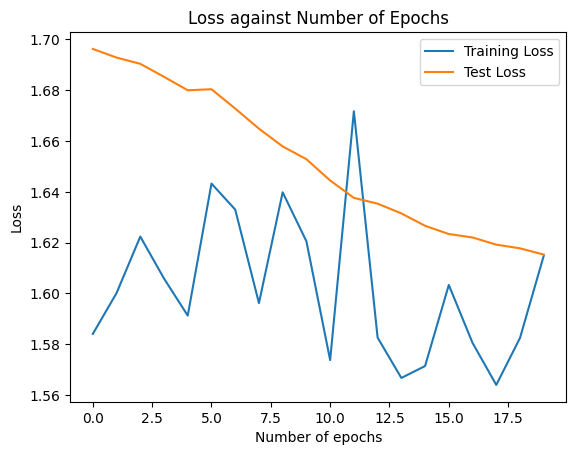

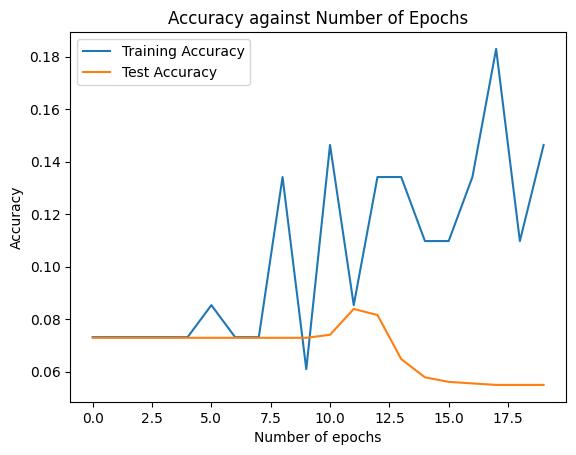

In [30]:
wbc_1_vanilla.plot_loss()
wbc_1_vanilla.plot_acc()
wbc_1_vanilla.save_best_model()

In [31]:
wbc_1_vanilla.classification_result()

Test Loss: 1.6153. Accuracy of the network on the 1728 Test images: 5.4977 %,
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.00      0.00      0.00       126
           2       0.00      0.00      0.00       412
           3       0.06      1.00      0.11        95
           4       0.00      0.00      0.00      1059

    accuracy                           0.05      1728
   macro avg       0.01      0.20      0.02      1728
weighted avg       0.00      0.05      0.01      1728



C:\Users\kan_h\.conda\envs\cs5242_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kan_h\.conda\envs\cs5242_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kan_h\.conda\envs\cs5242_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Vanilla - WBC10

In [8]:
wbc_10_vanilla = VanillaClassifier(model_name='wbc_10', train_path = r"../cs5242_project_dataset/WBC_10/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [9]:
wbc_10_vanilla.train_model()

Epoch [1/20], Loss: 1.6142, Train Accuracy: 7.2447 %
Test Loss: 1.6472. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.6068, Train Accuracy: 7.2447 %
Test Loss: 1.6252. Accuracy of the network on the 1728 Test images: 7.2917 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 1.6033, Train Accuracy: 7.3634 %
Test Loss: 1.6011. Accuracy of the network on the 1728 Test images: 7.4074 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 1.6042, Train Accuracy: 20.3088 %
Test Loss: 1.5112. Accuracy of the network on the 1728 Test images: 24.1319 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 1.5208, Train Accuracy: 25.5344 %
Test Loss: 1.2242. Accuracy of the network on the 1728 Test images: 25.5208 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 1.4760, Train Accuracy: 26.6033 %
Test Loss: 1.2282. Accuracy of the network on the 1728 Test images: 25.1157 %,
Epoch [7/20], Loss: 1.4266, Train Accuracy: 27.3159 %
Test Loss: 1.1542. Accuracy of the

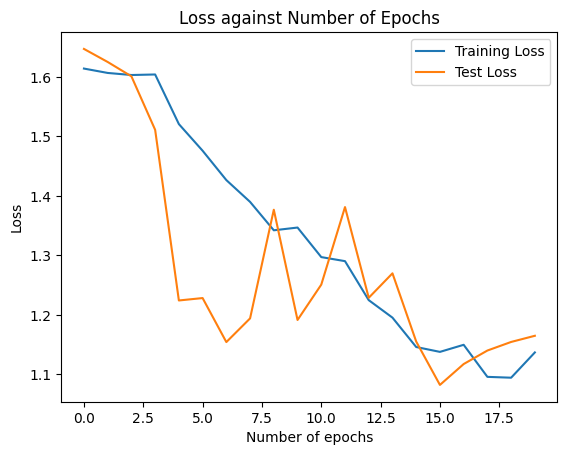

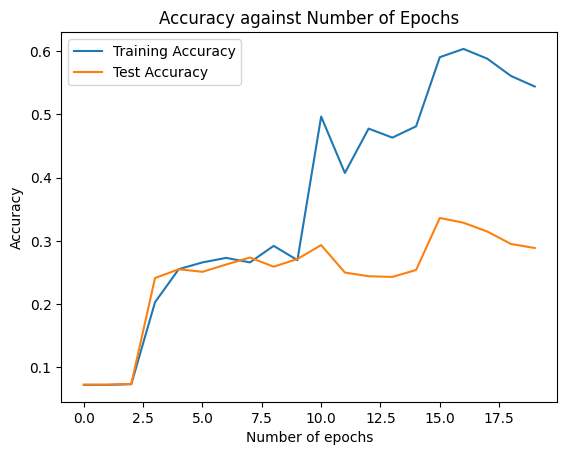

In [10]:
wbc_10_vanilla.plot_loss()
wbc_10_vanilla.plot_acc()
wbc_10_vanilla.save_best_model()

In [11]:
wbc_10_vanilla.classification_result()

Test Loss: 1.0822. Accuracy of the network on the 1728 Test images: 33.6227 %,
              precision    recall  f1-score   support

           0       0.13      0.06      0.08        36
           1       0.14      0.10      0.12       126
           2       0.28      0.94      0.43       412
           3       0.22      0.12      0.15        95
           4       0.88      0.16      0.27      1059

    accuracy                           0.34      1728
   macro avg       0.33      0.27      0.21      1728
weighted avg       0.63      0.34      0.29      1728



#### Vanilla - WBC50

In [29]:
wbc_50_vanilla = VanillaClassifier(model_name='wbc_50', train_path = r"../cs5242_project_dataset/WBC_50/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [30]:
wbc_50_vanilla.train_model()

Epoch [1/20], Loss: 1.6115, Train Accuracy: 5.5174 %
Test Loss: 1.6318. Accuracy of the network on the 1728 Test images: 5.4977 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.5958, Train Accuracy: 5.9436 %
Test Loss: 1.5517. Accuracy of the network on the 1728 Test images: 26.4468 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 1.4550, Train Accuracy: 20.5304 %
Test Loss: 1.1693. Accuracy of the network on the 1728 Test images: 26.3310 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 1.3139, Train Accuracy: 33.9095 %
Test Loss: 1.2174. Accuracy of the network on the 1728 Test images: 27.6620 %,
Epoch [5/20], Loss: 1.2235, Train Accuracy: 49.7040 %
Test Loss: 1.4133. Accuracy of the network on the 1728 Test images: 35.3009 %,
Epoch [6/20], Loss: 0.9220, Train Accuracy: 71.5605 %
Test Loss: 0.7520. Accuracy of the network on the 1728 Test images: 77.4884 %,
Saving state on Epoch 6
Epoch [7/20], Loss: 0.7488, Train Accuracy: 76.8411 %
Test Loss: 0.3934. Accuracy of the network on the 1728 

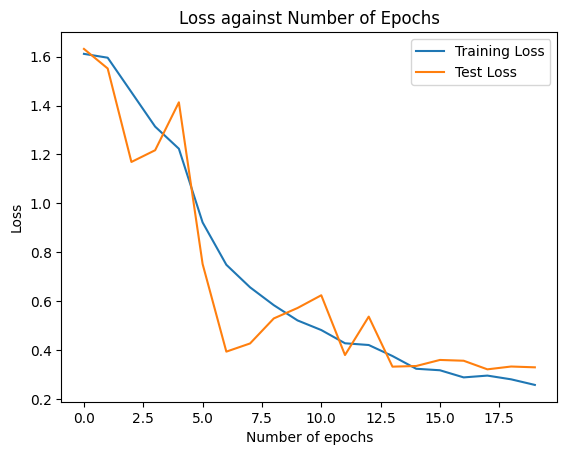

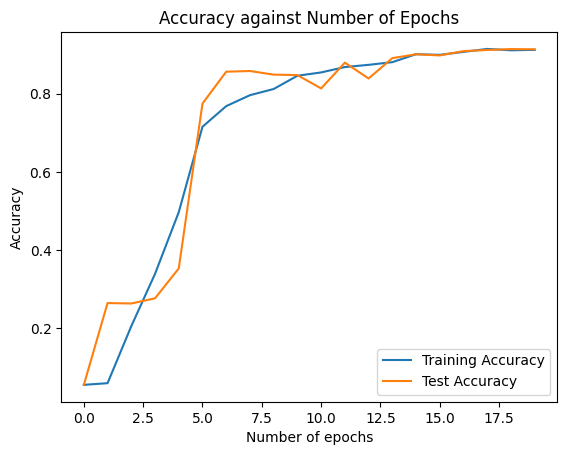

In [31]:
wbc_50_vanilla.plot_loss()
wbc_50_vanilla.plot_acc()
wbc_50_vanilla.save_best_model()

In [32]:
wbc_50_vanilla.classification_result()

Test Loss: 0.3210. Accuracy of the network on the 1728 Test images: 91.2037 %,
              precision    recall  f1-score   support

           0       0.86      0.69      0.77        36
           1       0.76      0.80      0.78       126
           2       0.87      0.93      0.90       412
           3       0.70      0.29      0.41        95
           4       0.95      0.98      0.97      1059

    accuracy                           0.91      1728
   macro avg       0.83      0.74      0.77      1728
weighted avg       0.91      0.91      0.90      1728



#### Vanilla - WBC100

In [32]:
wbc_100_vanilla = VanillaClassifier(model_name='wbc_100', 
                                    train_path = r"../cs5242_project_dataset/WBC_100/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [33]:
wbc_100_vanilla.train_model()

Epoch [1/20], Loss: 1.6019, Train Accuracy: 19.6875 %
Test Loss: 1.5919. Accuracy of the network on the 1728 Test images: 25.2894 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.4506, Train Accuracy: 27.0629 %
Test Loss: 1.1101. Accuracy of the network on the 1728 Test images: 26.6204 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 1.2011, Train Accuracy: 36.0838 %
Test Loss: 0.9654. Accuracy of the network on the 1728 Test images: 60.8796 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 1.0209, Train Accuracy: 61.9273 %
Test Loss: 0.8941. Accuracy of the network on the 1728 Test images: 66.8981 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 0.7229, Train Accuracy: 77.6844 %
Test Loss: 1.5512. Accuracy of the network on the 1728 Test images: 55.1505 %,
Epoch [6/20], Loss: 0.5834, Train Accuracy: 81.7805 %
Test Loss: 0.3278. Accuracy of the network on the 1728 Test images: 89.5255 %,
Saving state on Epoch 6
Epoch [7/20], Loss: 0.4947, Train Accuracy: 84.6218 %
Test Loss: 0.4613. Accuracy 

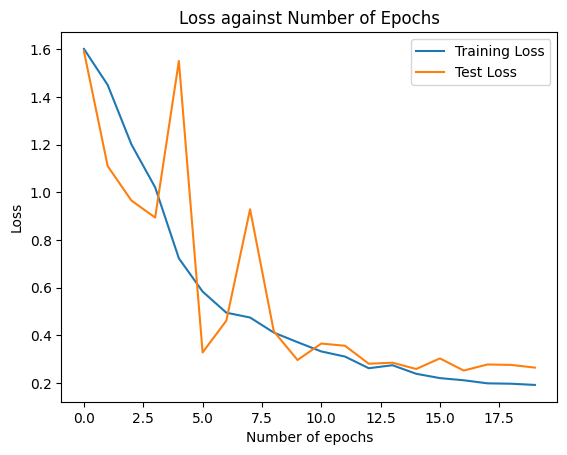

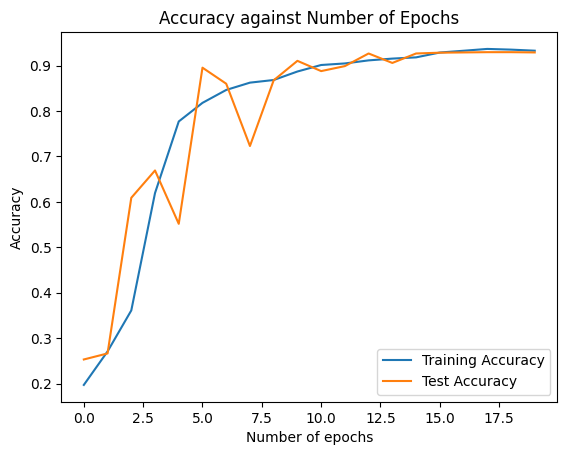

In [34]:
wbc_100_vanilla.plot_loss()
wbc_100_vanilla.plot_acc()
wbc_100_vanilla.save_best_model()

In [35]:
wbc_100_vanilla.classification_result()

Test Loss: 0.2519. Accuracy of the network on the 1728 Test images: 92.8819 %,
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.70      0.92      0.80       126
           2       0.89      0.97      0.93       412
           3       0.83      0.41      0.55        95
           4       0.99      0.96      0.98      1059

    accuracy                           0.93      1728
   macro avg       0.86      0.82      0.82      1728
weighted avg       0.93      0.93      0.93      1728



## Train with additional information

### Define Helper functions

In [13]:
class Resize():
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = functional.resize(image, self.size)
        target = functional.resize(target, self.size)
        return image, target

class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomCrop():
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        # image = pad_if_smaller(image, self.size)
        # target = pad_if_smaller(target, self.size, fill=255)
        crop_params = transforms.RandomCrop.get_params(image, (self.size, self.size))
        image = functional.crop(image, *crop_params)
        target = functional.crop(target, *crop_params)
        return image, target
        
class Normalize():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, image, target):
        image = functional.normalize(image, mean=self.mean, std=self.std)
        return image, target

class PILToTensor():
    def __call__(self, image, target):
        image = functional.pil_to_tensor(image)
        target = functional.pil_to_tensor(target)
        # target = torch.as_tensor(np.array(target), dtype=torch.uint8)
        return image, target

class ConvertImageDtype:
    def __init__(self, dtype):
        self.dtype = dtype

    def __call__(self, image, target):
        image = functional.convert_image_dtype(image, self.dtype)
        target = functional.convert_image_dtype(target, self.dtype)
        return image, target

In [14]:
class SegmentationDataset(Dataset):
    def __init__(self, maskPaths, transforms):
    # store the image and mask filepaths, and augmentation
    # transforms
        # "../cs5242_project_dataset/CAM16_100cls_10mask/train/mask/*"
        self.maskPaths = glob.glob(os.path.join(maskPaths,"*.jpg"))
        self.imagePaths = [x.replace('/mask', '/data') for x in self.maskPaths]
        self.transforms = transforms
        # self.transforms_mask = transforms_mask
    
    def __len__(self):
    # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        image = Image.open(imagePath) 
        mask =  Image.open(maskPath).convert('RGB')
        # check to see if we are applying any transformations
        if self.transforms is not None:
        # apply the transformations to both image and its mask
            image, mask = self.transforms(image, mask)
            # mask = self.transforms_mask(mask)
        # return a tuple of the image and its mask
        return (image, mask)

In [15]:
class WBCSegmentation():
    def __init__(self, model_name, train_path):
        self.model_name = model_name
        self.batch_size = 64
        self.latent_size = 1000
        self.num_class = 5
        self.learning_rate = 1e-4
        self.num_epochs = 20
        self.transform = Compose(
                            	[Resize(size=400),
                            	RandomCrop(size = 224),
                            	PILToTensor(),
                                ConvertImageDtype(torch.float),
                            	Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

        self.train_path = train_path
        
        # r"../cs5242_project_dataset/WBC_10/train/mask/*/"
        full_dataset = SegmentationDataset(self.train_path, transforms = self.transform)
        # full_dataset=torchvision.datasets.ImageFolder(train_path)
        train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
    
        self.train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True , batch_size = self.batch_size )

        self.test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = False , batch_size = self.batch_size )

        self.model = self.initialize_model()
        self.training_loss = []
        # self.training_acc = []
        self.testing_loss = []
        # self.testing_acc = []
        self.valid_loss_min = np.Inf
        self.best_epoch = 0
        self.best_epoch_state = None
        
    def get_train_dataloader(self):
        return self.train_loader
    def get_test_dataloader(self):
        return self.test_loader

    def initialize_model(self):
        encoder_pretrained = Encoder(BasicBlock, [2, 2, 2, 2])
        encoder_pretrained.fc = nn.Linear(512, self.latent_size)
        autoencoder = Autoencoder(encoder_pretrained, self.latent_size)

        return autoencoder

    def train_model(self):
        self.model.to(device)
        # classification_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        # sched = torch.optim.lr_scheduler.OneCycleLR(classification_optimizer, self.learning_rate, epochs=self.num_epochs, 
        #                                         steps_per_epoch=len(self.train_loader))
        # class_weights_tensor = self.get_class_weights(self.labels)
        
        
        autoencoder_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        autoencoder_criterion = nn.MSELoss()  
        
        train_loader = self.get_train_dataloader()
        test_loader = self.get_test_dataloader()
        
        for epoch in range(1, self.num_epochs+1):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                autoencoder_optimizer.zero_grad()
        
                outputs = self.model(images)
                loss = autoencoder_criterion(outputs, labels)      
                
                # Backward and optimize
                loss.backward()
                autoencoder_optimizer.step()
                train_loss += loss.item()
                
            train_loss_epoch = train_loss/len(train_loader)
            self.training_loss.append(train_loss_epoch)
            print('Epoch: {} \tTraining Loss: {:.6f}'.format( epoch, train_loss_epoch))
                
            # Test
            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0

                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    loss = autoencoder_criterion(outputs, labels)
                    total += labels.size(0)
                    test_loss += loss.item()
                    test_loss_epoch = test_loss/len(test_loader)
                print('Test Loss: {:.4f}. On network with {} Test images'.format(test_loss_epoch, total))
                self.testing_loss.append(test_loss_epoch)
                
                
                network_learned = test_loss_epoch < self.valid_loss_min
                # print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
                if network_learned:
                    print(f"Saving state on Epoch {epoch}")
                    self.valid_loss_min = test_loss_epoch
                    self.best_epoch = epoch
                    self.best_epoch_state = copy.deepcopy(self.model.state_dict())
            self.model.train()

    def save_best_model(self):
        torch.save(self.best_epoch_state, f'./checkpoints/{self.model_name}_wbc_seg_epoch_{self.best_epoch}.pth')
    
    def plot_loss(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_loss[:self.num_epochs], label="Training Loss")
        plt.plot(ep, self.testing_loss[:self.num_epochs], label="Test Loss")
        
        plt.title("Loss against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def set_model_state(self, model_state):
        self.model.load_state_dict(model_state)
        
    def get_model_state(self):
        return self.best_epoch_state
        
    def get_model(self):
        return copy.deepcopy(self.model)

    def plot_image(self, image, name):
    # image = image
        plt.figure(figsize=(1,1))
        plt.imshow((image.permute(1, 2, 0)).detach().squeeze().cpu().numpy(), cmap='gray')  # Move data back to CPU for visualization
        plt.title(name)
        plt.show()
    def visualize_reconstructed(self, i):
        test_loader = self.get_test_dataloader()
        autoencoder_criterion = nn.MSELoss()  
        with torch.no_grad():
            self.model.eval()
            correct = 0
            total = 0
            test_loss = 0

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = autoencoder_criterion(outputs, labels)
                total += labels.size(0)
                test_loss += loss.item()
                test_loss_epoch = test_loss/len(test_loader)
            print('Test Loss: {:.4f}. On network with {} Test images'.format(test_loss_epoch, total))
            self.testing_loss.append(test_loss_epoch)
        self.plot_image(outputs[i], "Predicted Mask")
        self.plot_image(labels[i], "Actual Mask")
        
        


### Autoencoder Training

In [16]:
class AutoEncoderTrainer():
    def __init__(self, model_name, train_path, test_path=None):
        self.model_name = model_name
        self.batch_size = 64
        self.latent_size = 1000
        self.num_class = 5
        self.learning_rate = 1e-4
        self.num_epochs = 20
        self.transform = transforms.Compose(
        	[
        	transforms.Resize((224,224)),
        	transforms.ToTensor(),
        	transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])

        self.train_path = train_path
        self.test_path = test_path
        
        if self.test_path != None: 
            # "../cs5242_project_dataset/WBC_100/train/data"
            self.trainset=torchvision.datasets.ImageFolder(self.train_path, transform=self.transform, target_transform=None)
            self.train_loader = torch.utils.data.DataLoader(self.trainset, shuffle = True , batch_size = self.batch_size , num_workers = 2)
            
            self.testset=torchvision.datasets.ImageFolder(test_path, transform=self.transform, target_transform=None)
            self.test_loader = torch.utils.data.DataLoader(self.testset, shuffle = False , batch_size = self.batch_size , num_workers = 2)
        else:
            full_dataset=torchvision.datasets.ImageFolder(train_path)
            train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
            trainset = DatasetFromSubset(train_dataset, self.transform)
            testset = DatasetFromSubset(test_dataset, self.transform)
            self.train_loader = torch.utils.data.DataLoader(trainset, shuffle = True , batch_size = self.batch_size )
            self.test_loader = torch.utils.data.DataLoader(testset, shuffle = False , batch_size = self.batch_size )
                    
        self.model = self.initialize_model()
        self.training_loss = []
        # self.training_acc = []
        self.testing_loss = []
        # self.testing_acc = []
        self.valid_loss_min = np.Inf
        self.best_epoch = 0
        self.best_epoch_state = None
        
    def get_train_dataloader(self):
        return self.train_loader
    def get_test_dataloader(self):
        return self.test_loader

    def initialize_model(self):
        encoder_pretrained = Encoder(BasicBlock, [2, 2, 2, 2])
        encoder_pretrained.fc = nn.Linear(512, self.latent_size)
        autoencoder = Autoencoder(encoder_pretrained, self.latent_size)

        return autoencoder

    def train_model(self):
        self.model.to(device)
        # classification_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        # sched = torch.optim.lr_scheduler.OneCycleLR(classification_optimizer, self.learning_rate, epochs=self.num_epochs, 
        #                                         steps_per_epoch=len(self.train_loader))
        # class_weights_tensor = self.get_class_weights(self.labels)
        
        
        autoencoder_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        autoencoder_criterion = nn.MSELoss()  
        
        train_loader = self.get_train_dataloader()
        test_loader = self.get_test_dataloader()
        
        for epoch in range(1, self.num_epochs+1):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                autoencoder_optimizer.zero_grad()
        
                outputs = self.model(images)
                loss = autoencoder_criterion(outputs, images)      
                
                # Backward and optimize
                loss.backward()
                autoencoder_optimizer.step()
                train_loss += loss.item()
                
            train_loss_epoch = train_loss/len(train_loader)
            self.training_loss.append(train_loss_epoch)
            print('Epoch: {} \tTraining Loss: {:.6f}'.format( epoch, train_loss_epoch))
                
            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
    
                for images, _ in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    loss = autoencoder_criterion(outputs, images)
                    total += images.size(0)
                    test_loss += loss.item()
                    test_loss_epoch = test_loss/len(test_loader)
                print('Test Loss: {:.4f}. On network with {} Test images'.format(test_loss_epoch, total))
                self.testing_loss.append(test_loss_epoch)

                network_learned = test_loss_epoch < self.valid_loss_min
                # print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
                if network_learned:
                    print(f"Saving state on Epoch {epoch}")
                    self.valid_loss_min = test_loss_epoch
                    self.best_epoch = epoch
                    self.best_epoch_state = copy.deepcopy(self.model.state_dict())
            self.model.train()

    def save_best_model(self):
        torch.save(self.best_epoch_state, f'./checkpoints/{self.model_name}_autoencoder_epoch_{self.best_epoch}.pth')
    
    def plot_loss(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_loss[:self.num_epochs], label="Training Loss")
        plt.plot(ep, self.testing_loss[:self.num_epochs], label="Test Loss")
        
        plt.title("Loss against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def set_model_state(self, model_state):
        self.model.load_state_dict(model_state)
    def get_model_state(self):
        return self.best_epoch_state
        
    def get_model(self):
        return copy.deepcopy(self.model)

    def plot_image(self, image, name):
    # image = image
        plt.figure(figsize=(1,1))
        plt.imshow((image.permute(1, 2, 0)).detach().squeeze().cpu().numpy(), cmap='gray')  # Move data back to CPU for visualization
        plt.title(name)
        plt.show()
    def visualize_reconstructed(self, i):
        test_loader = self.get_test_dataloader()
        autoencoder_criterion = nn.MSELoss()  
        with torch.no_grad():
            self.model.eval()
            correct = 0
            total = 0
            test_loss = 0

            for images, _ in test_loader:
                images = images.to(device)
                # labels = labels.to(device)
                outputs = self.model(images)
                loss = autoencoder_criterion(outputs, images)
                total += images.size(0)
                test_loss += loss.item()
                test_loss_epoch = test_loss/len(test_loader)
            print('Test Loss: {:.4f}. On network with {} Test images'.format(test_loss_epoch, total))
            self.testing_loss.append(test_loss_epoch)
        self.plot_image(outputs[i], "Predicted Mask")
        self.plot_image(images[i], "Actual Mask")
        
        


### Use autoencoder pretrained weights to train classifier

In [17]:
def create_classifier_state_from_autoencoder(model_state, num_classes):
    latent_size = 1000
    num_class = num_classes
    encoder = Encoder(BasicBlock, [2, 2, 2, 2])
    encoder.fc = nn.Linear(512, latent_size)
    autoencoder_add_info = Autoencoder(encoder, latent_size)
    autoencoder_add_info.load_state_dict(model_state)
    classifier = Classification(autoencoder_add_info.encoder, latent_size, num_class)
    return classifier

In [18]:
class CAM16Classifier():
    def __init__(self, model_name, train_path, test_path=None):
        self.model_name = model_name
        self.batch_size = 64
        self.latent_size = 1000
        self.num_class = 2
        self.learning_rate = 1e-4
        self.num_epochs = 20
        self.transform = transforms.Compose([
                            	transforms.Resize((224,224)),
                                transforms.RandomAffine(degrees=(-10, 10), translate=(0,0.2), scale=(0.8,1.2), shear=(-20,20)),
                                transforms.RandomRotation(degrees=(0, 180)),
                            	transforms.ToTensor(),
                            	transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])

        self.transform_test = transforms.Compose([transforms.Resize((400,400)),
                                    transforms.CenterCrop((224,224)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        self.train_path = train_path
        self.test_path = test_path
        
        if self.test_path != None: 
            # "../cs5242_project_dataset/WBC_100/train/data"
            self.trainset=torchvision.datasets.ImageFolder(self.train_path, transform=self.transform, target_transform=None)
            self.train_loader = torch.utils.data.DataLoader(self.trainset, shuffle = True , batch_size = self.batch_size , num_workers = 2)
            
            self.testset=torchvision.datasets.ImageFolder(test_path, transform=self.transform_test, target_transform=None)
            self.test_loader = torch.utils.data.DataLoader(self.testset, shuffle = False , batch_size = self.batch_size , num_workers = 2)
            self.labels = self.trainset.targets
        else:
            full_dataset=torchvision.datasets.ImageFolder(train_path)
            train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
            trainset = DatasetFromSubset(train_dataset, self.transform)
            testset = DatasetFromSubset(test_dataset, self.transform_test)
            self.train_loader = torch.utils.data.DataLoader(trainset, shuffle = True , batch_size = self.batch_size )

            self.test_loader = torch.utils.data.DataLoader(testset, shuffle = False , batch_size = self.batch_size )
        
            self.labels = full_dataset.targets
            
        self.class_weights_tensor = self.get_class_weights(self.labels)
        self.model = self.initialize_model()
        self.training_loss = []
        self.training_acc = []
        self.testing_loss = []
        self.testing_acc = []
        self.valid_loss_min = np.Inf
        self.best_epoch = 0
        self.best_epoch_state = None
        
    def get_train_dataloader(self):
        return self.train_loader
        
    def get_test_dataloader(self):
        return self.test_loader

    def get_class_weights(self, labels):
        unique_labels = np.unique(labels)
        class_weights = compute_class_weight(class_weight ='balanced', classes = unique_labels, y = labels)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)
   
        return class_weights_tensor

    def initialize_model(self):
        encoder_pretrained = Encoder(BasicBlock, [2, 2, 2, 2])
        encoder_pretrained.fc = nn.Linear(512, self.latent_size)
        classification = Classification(encoder_pretrained, self.latent_size, self.num_class)
        return classification

    def train_model(self):
        self.model.to(device)
        classification_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        sched = torch.optim.lr_scheduler.OneCycleLR(classification_optimizer, self.learning_rate, epochs=self.num_epochs, 
                                                steps_per_epoch=len(self.train_loader))
        classification_criterion = nn.CrossEntropyLoss()#nn.NLLLoss()
        
        train_loader = self.get_train_dataloader()
        test_loader = self.get_test_dataloader()
        
        for epoch in range(1, self.num_epochs+1):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                classification_optimizer.zero_grad()
        
                outputs = self.model(images)
                loss = classification_criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
        
                
                # Backward and optimize
                loss.backward()
                classification_optimizer.step()
                train_loss += loss.item()
                sched.step()
                
            train_loss_epoch = train_loss/len(train_loader)
            train_acc = train_correct/train_total
            self.training_acc.append(train_acc)
            self.training_loss.append(train_loss_epoch)
            print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f} %' 
                               .format(epoch, self.num_epochs, train_loss_epoch, train_acc * 100))
            
            # Test
            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
                labels_list = []
                pred_list = []
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    loss = classification_criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += loss.item()
        
                    labels_list.extend(labels.cpu().numpy())
                    pred_list.extend(predicted.cpu().numpy())
                    
                test_loss_epoch = test_loss/len(test_loader)
                test_acc = correct / total
                # if epoch % 10 == 0:
                print('Test Loss: {:.4f}. Accuracy of the network on the {} Test images: {:.4f} %,'.format(test_loss_epoch, total, 100 * test_acc))
                self.testing_acc.append(test_acc)
                self.testing_loss.append(test_loss_epoch)
                
                network_learned = test_loss_epoch < self.valid_loss_min
                # print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
                if network_learned:
                    print(f"Saving state on Epoch {epoch}")
                    self.valid_loss_min = test_loss_epoch
                    self.best_epoch = epoch
                    self.best_epoch_state = copy.deepcopy(self.model.state_dict())
            self.model.train()

    def set_model_state(self, model_state):
        self.model.load_state_dict(model_state)
        
    def get_model_state(self):
        return self.best_epoch_state
        
    def get_model(self):
        return copy.deepcopy(self.model)

    def save_best_model(self):
        torch.save(self.best_epoch_state, f'./checkpoints/classifier_{self.model_name}_epoch_{self.best_epoch}.pth')
    def freeze_layers(self, num_encoder_to_freeze):
        num_layers = len(list(self.model.encoder.children()))

        for idx, child in enumerate(self.model.encoder.children()):
            if idx < num_encoder_to_freeze:
                for param in child.parameters():
                    param.requires_grad = False
    
    def plot_loss(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_loss[:self.num_epochs], label="Training Loss")
        plt.plot(ep, self.testing_loss[:self.num_epochs], label="Test Loss")
        
        plt.title("Loss against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    def plot_acc(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_acc[:self.num_epochs], label="Training Accuracy")
        plt.plot(ep, self.testing_acc[:self.num_epochs], label="Test Accuracy")
        plt.title("Accuracy against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def classification_result(self):
        self.model.load_state_dict(self.best_epoch_state)
        test_loader = self.get_test_dataloader()
        self.model.to(device)
        classification_criterion = nn.CrossEntropyLoss()#nn.NLLLoss()
        with torch.no_grad():
            self.model.eval()
            correct = 0
            total = 0
            test_loss = 0
            labels_list = []
            pred_list = []
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = classification_criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
        
                labels_list.extend(labels.cpu().numpy())
                pred_list.extend(predicted.cpu().numpy())
                
            test_loss_epoch = test_loss/len(test_loader)
            test_acc = correct / total
            print('Test Loss: {:.4f}. Accuracy of the network on the {} Test images: {:.4f} %,'.format(test_loss_epoch, total, 100 * test_acc))
            print(classification_report(labels_list, pred_list))

### Train classifier with additional information

In [19]:
class AddInfoClassifier():
    def __init__(self, model_name, train_path, test_path=None):
        self.model_name = model_name
        self.batch_size = 64
        self.latent_size = 1000
        self.num_class = 5
        self.learning_rate = 1e-4
        self.num_epochs = 20
        self.transform = transforms.Compose(
                	[
                    transforms.Resize((400,400)),
                    transforms.CenterCrop((224,224)),
                    transforms.ColorJitter(brightness=.7, hue=.3),
                    transforms.RandomAffine(degrees=(-10, 10), translate=(0,0.2), scale=(0.8,1.2), shear=(-20,20)),
                    transforms.RandomRotation(degrees=(0, 180)),
                	transforms.ToTensor(),
                	transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
                )
        self.transform_test = transforms.Compose([transforms.Resize((400,400)),
                                    transforms.CenterCrop((224,224)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        self.train_path = train_path
        self.test_path = test_path
        
        if self.test_path != None: 
            # "../cs5242_project_dataset/WBC_100/train/data"
            self.trainset=torchvision.datasets.ImageFolder(self.train_path, transform=self.transform, target_transform=None)
            self.train_loader = torch.utils.data.DataLoader(self.trainset, shuffle = True , batch_size = self.batch_size , num_workers = 2)
            
            self.testset=torchvision.datasets.ImageFolder(test_path, transform=self.transform_test, target_transform=None)
            self.test_loader = torch.utils.data.DataLoader(self.testset, shuffle = False , batch_size = self.batch_size , num_workers = 2)
            self.labels = self.trainset.targets
        else:
            full_dataset=torchvision.datasets.ImageFolder(train_path)
            train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
            trainset = DatasetFromSubset(train_dataset, self.transform)
            testset = DatasetFromSubset(test_dataset, self.transform_test)
            self.train_loader = torch.utils.data.DataLoader(trainset, shuffle = True , batch_size = self.batch_size )

            self.test_loader = torch.utils.data.DataLoader(testset, shuffle = False , batch_size = self.batch_size )
        
            self.labels = full_dataset.targets
            
        self.class_weights_tensor = self.get_class_weights(self.labels)
        self.model = self.initialize_model()
        self.training_loss = []
        self.training_acc = []
        self.testing_loss = []
        self.testing_acc = []
        self.valid_loss_min = np.Inf
        self.best_epoch = 0
        self.best_epoch_state = None
        
    def get_train_dataloader(self):
        return self.train_loader
        
    def get_test_dataloader(self):
        return self.test_loader

    def get_class_weights(self, labels):
        unique_labels = np.unique(labels)
        class_weights = compute_class_weight(class_weight ='balanced', classes = unique_labels, y = labels)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)
   
        return class_weights_tensor

    def initialize_model(self):
        encoder_pretrained = Encoder(BasicBlock, [2, 2, 2, 2])
        encoder_pretrained.fc = nn.Linear(512, self.latent_size)
        classification = Classification(encoder_pretrained, self.latent_size, self.num_class)
        return classification

    def train_model(self):
        self.model.to(device)
        classification_optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)
        sched = torch.optim.lr_scheduler.OneCycleLR(classification_optimizer, self.learning_rate, epochs=self.num_epochs, 
                                                steps_per_epoch=len(self.train_loader))
        class_weights_tensor = self.get_class_weights(self.labels)
        classification_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)#nn.NLLLoss()
        
        train_loader = self.get_train_dataloader()
        test_loader = self.get_test_dataloader()
        
        for epoch in range(1, self.num_epochs+1):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                classification_optimizer.zero_grad()
        
                outputs = self.model(images)
                loss = classification_criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
        
                
                # Backward and optimize
                loss.backward()
                classification_optimizer.step()
                train_loss += loss.item()
                sched.step()
                
            train_loss_epoch = train_loss/len(train_loader)
            train_acc = train_correct/train_total
            self.training_acc.append(train_acc)
            self.training_loss.append(train_loss_epoch)
            print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f} %' 
                               .format(epoch, self.num_epochs, train_loss_epoch, train_acc * 100))
            
            # Test
            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
                labels_list = []
                pred_list = []
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    loss = classification_criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += loss.item()
        
                    labels_list.extend(labels.cpu().numpy())
                    pred_list.extend(predicted.cpu().numpy())
                    
                test_loss_epoch = test_loss/len(test_loader)
                test_acc = correct / total
                # if epoch % 10 == 0:
                print('Test Loss: {:.4f}. Accuracy of the network on the {} Test images: {:.4f} %,'.format(test_loss_epoch, total, 100 * test_acc))
                self.testing_acc.append(test_acc)
                self.testing_loss.append(test_loss_epoch)
                
                network_learned = test_loss_epoch < self.valid_loss_min
                # print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
                if network_learned:
                    print(f"Saving state on Epoch {epoch}")
                    self.valid_loss_min = test_loss_epoch
                    self.best_epoch = epoch
                    self.best_epoch_state = copy.deepcopy(self.model.state_dict())
            self.model.train()

    def set_model_state(self, model_state):
        self.model.load_state_dict(model_state, strict=False)
        
    def get_model_state(self):
        return self.best_epoch_state
        
    def get_model(self):
        return copy.deepcopy(self.model)

    def save_best_model(self):
        torch.save(self.best_epoch_state, f'./checkpoints/classifier_{self.model_name}_epoch_{self.best_epoch}.pth')
    def freeze_layers(self, num_encoder_to_freeze):
        num_layers = len(list(self.model.encoder.children()))

        for idx, child in enumerate(self.model.encoder.children()):
            if idx < num_encoder_to_freeze:
                for param in child.parameters():
                    param.requires_grad = False
    
    def plot_loss(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_loss[:self.num_epochs], label="Training Loss")
        plt.plot(ep, self.testing_loss[:self.num_epochs], label="Test Loss")
        
        plt.title("Loss against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    def plot_acc(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_acc[:self.num_epochs], label="Training Accuracy")
        plt.plot(ep, self.testing_acc[:self.num_epochs], label="Test Accuracy")
        plt.title("Accuracy against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def classification_result(self):
        self.model.load_state_dict(self.best_epoch_state)
        test_loader = self.get_test_dataloader()
        self.model.to(device)
        class_weights_tensor = self.get_class_weights(self.labels)
        classification_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)#nn.NLLLoss()
        with torch.no_grad():
            self.model.eval()
            correct = 0
            total = 0
            test_loss = 0
            labels_list = []
            pred_list = []
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = classification_criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
        
                labels_list.extend(labels.cpu().numpy())
                pred_list.extend(predicted.cpu().numpy())
                
            test_loss_epoch = test_loss/len(test_loader)
            test_acc = correct / total
            print('Test Loss: {:.4f}. Accuracy of the network on the {} Test images: {:.4f} %,'.format(test_loss_epoch, total, 100 * test_acc))
            print(classification_report(labels_list, pred_list))

#### Additional Info - WBC1

Epoch: 1 	Training Loss: 0.245201
Test Loss: 0.2467. On network with 1 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.244683
Test Loss: 0.2470. On network with 1 Test images
Epoch: 3 	Training Loss: 0.242903
Test Loss: 0.2464. On network with 1 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.241824
Test Loss: 0.2464. On network with 1 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.240814
Test Loss: 0.2467. On network with 1 Test images
Epoch: 6 	Training Loss: 0.240396
Test Loss: 0.2480. On network with 1 Test images
Epoch: 7 	Training Loss: 0.234141
Test Loss: 0.2490. On network with 1 Test images
Epoch: 8 	Training Loss: 0.239780
Test Loss: 0.2450. On network with 1 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.228819
Test Loss: 0.2415. On network with 1 Test images
Saving state on Epoch 9
Epoch: 10 	Training Loss: 0.227943
Test Loss: 0.2406. On network with 1 Test images
Saving state on Epoch 10
Epoch: 11 	Training Loss

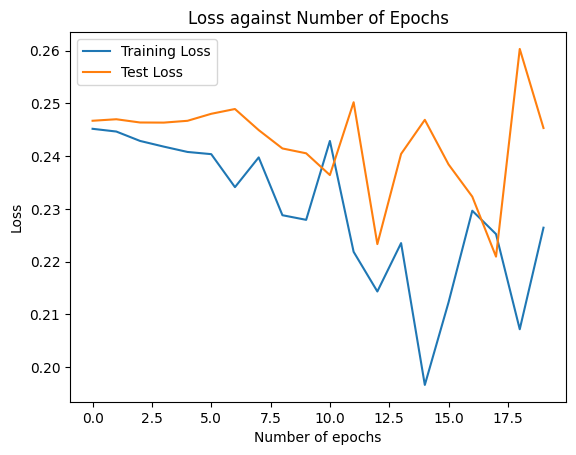

In [22]:
wbc_seg_1 = WBCSegmentation("WBC1_seg", r"../cs5242_project_dataset/WBC_1/train/mask/*/")
wbc_seg_1.train_model()
wbc_seg_1.plot_loss()
wbc_seg_1.save_best_model()

Epoch: 1 	Training Loss: 1.019508
Test Loss: 0.9855. On network with 151 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.973961
Test Loss: 0.9592. On network with 151 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.930420
Test Loss: 0.8570. On network with 151 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.787247
Test Loss: 0.7402. On network with 151 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.674599
Test Loss: 0.7021. On network with 151 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.620286
Test Loss: 0.6394. On network with 151 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.595134
Test Loss: 0.6485. On network with 151 Test images
Epoch: 8 	Training Loss: 0.579945
Test Loss: 0.5996. On network with 151 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.566153
Test Loss: 0.5677. On network with 151 Test images
Saving state on Epoch 9
Epoch: 10 	Training Loss: 0.552846
Test Los

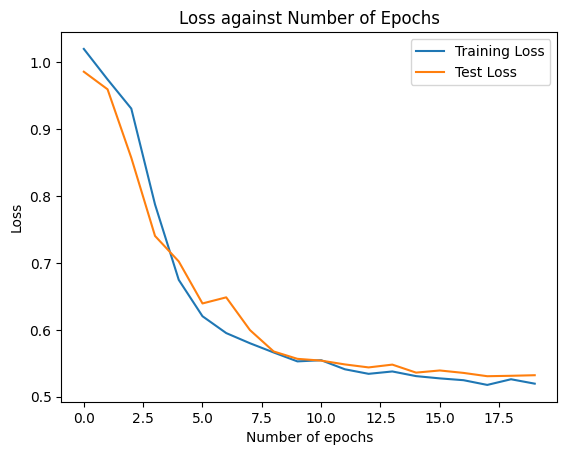

In [23]:
cam16_ae_1 = AutoEncoderTrainer("cam16_ae_1", r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data")

cam16_ae_1.set_model_state(wbc_seg_1.get_model_state())
cam16_ae_1.train_model()
cam16_ae_1.plot_loss()
cam16_ae_1.save_best_model()

Epoch: 1 	Training Loss: 0.683202
Test Loss: 0.6810. On network with 283 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.676970
Test Loss: 0.6739. On network with 283 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.671145
Test Loss: 0.6695. On network with 283 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.674529
Test Loss: 0.6696. On network with 283 Test images
Epoch: 5 	Training Loss: 0.673708
Test Loss: 0.6729. On network with 283 Test images
Epoch: 6 	Training Loss: 0.668778
Test Loss: 0.6673. On network with 283 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.666913
Test Loss: 0.6646. On network with 283 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.665194
Test Loss: 0.6658. On network with 283 Test images
Epoch: 9 	Training Loss: 0.666100
Test Loss: 0.6653. On network with 283 Test images
Epoch: 10 	Training Loss: 0.663457
Test Loss: 0.6670. On network with 283 Test images
Epoch: 11 	Training Loss: 0.6

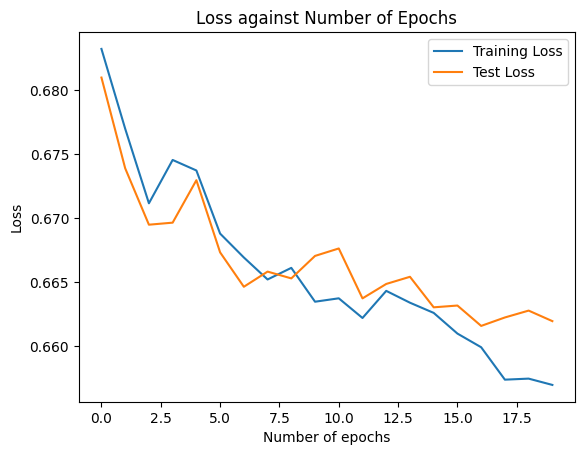

In [24]:
cam16_ae_1_state = cam16_ae_1.get_model_state()
del cam16_ae_1
gc.collect()
torch.cuda.empty_cache()
prcc_ae_1 = AutoEncoderTrainer("prcc_ae_1", r"../cs5242_project_dataset/pRCC_nolabel/")
prcc_ae_1.set_model_state(cam16_ae_1_state)
prcc_ae_1.train_model()
prcc_ae_1.plot_loss()
prcc_ae_1.save_best_model()

Epoch: 1 	Training Loss: 0.493767
Test Loss: 0.4105. On network with 16 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.441496
Test Loss: 0.4140. On network with 16 Test images
Epoch: 3 	Training Loss: 0.442350
Test Loss: 0.4129. On network with 16 Test images
Epoch: 4 	Training Loss: 0.423248
Test Loss: 0.4101. On network with 16 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.398607
Test Loss: 0.4144. On network with 16 Test images
Epoch: 6 	Training Loss: 0.557058
Test Loss: 0.4032. On network with 16 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.593112
Test Loss: 0.3935. On network with 16 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.403673
Test Loss: 0.3957. On network with 16 Test images
Epoch: 9 	Training Loss: 0.381951
Test Loss: 0.3958. On network with 16 Test images
Epoch: 10 	Training Loss: 0.346918
Test Loss: 0.3953. On network with 16 Test images
Epoch: 11 	Training Loss: 0.408358
Test Loss: 0.3969. On networ

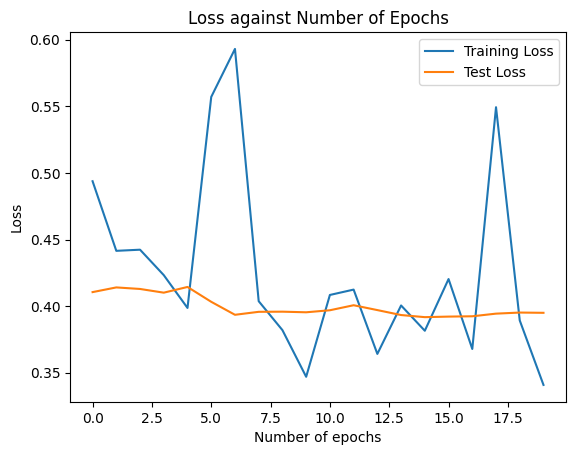

In [25]:
prcc_ae_1_state = prcc_ae_1.get_model_state()
del prcc_ae_1
gc.collect()
torch.cuda.empty_cache()
wbc_ae_1 = AutoEncoderTrainer("wbc_ae_1", r"../cs5242_project_dataset/WBC_1/train/data")
wbc_ae_1.set_model_state(prcc_ae_1_state)
wbc_ae_1.train_model()
wbc_ae_1.plot_loss()
wbc_ae_1.save_best_model()

Epoch [1/20], Loss: 0.6859, Train Accuracy: 52.3118 %
Test Loss: 0.6629. Accuracy of the network on the 108 Test images: 64.8148 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 0.6622, Train Accuracy: 68.0317 %
Test Loss: 0.6338. Accuracy of the network on the 108 Test images: 69.4444 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 0.6248, Train Accuracy: 70.4095 %
Test Loss: 0.5724. Accuracy of the network on the 108 Test images: 75.0000 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 0.5335, Train Accuracy: 80.0528 %
Test Loss: 0.4089. Accuracy of the network on the 108 Test images: 85.1852 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 0.3952, Train Accuracy: 85.6011 %
Test Loss: 0.3639. Accuracy of the network on the 108 Test images: 84.2593 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 0.3285, Train Accuracy: 86.9221 %
Test Loss: 0.4008. Accuracy of the network on the 108 Test images: 87.0370 %,
Epoch [7/20], Loss: 0.2996, Train Accuracy: 86.6579 %
Test Loss: 0.4250. Accuracy of the

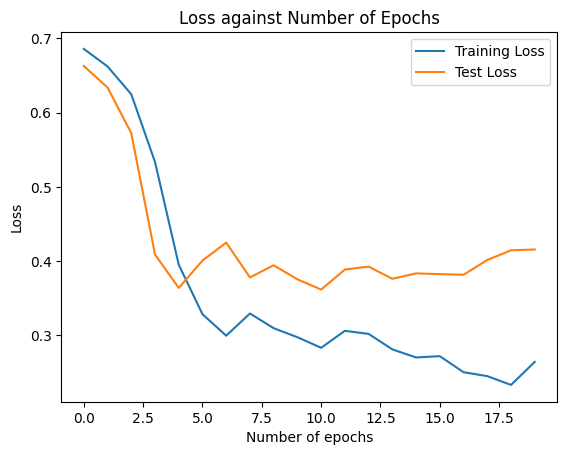

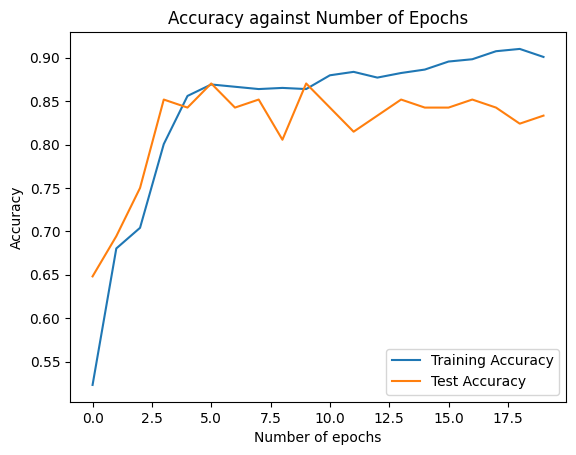

In [26]:
state = wbc_ae_1.get_model_state()
del wbc_ae_1
gc.collect()
torch.cuda.empty_cache()
CAM16Classifier_1 = CAM16Classifier(model_name='cam_1', 
                                    train_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data",
                                   test_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/val/data")
modified_state = create_classifier_state_from_autoencoder(state,2).state_dict()
CAM16Classifier_1.set_model_state(modified_state)
CAM16Classifier_1.freeze_layers(6)
CAM16Classifier_1.train_model()
CAM16Classifier_1.plot_loss()
CAM16Classifier_1.plot_acc()
CAM16Classifier_1.save_best_model()

In [27]:
AddInfoClassifier_1 = AddInfoClassifier(model_name='add_info_classifier_1', 
                                    train_path = r"../cs5242_project_dataset/WBC_1/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [28]:
CAM16Classifier_1_state = CAM16Classifier_1.get_model_state()
del CAM16Classifier_1
gc.collect()
torch.cuda.empty_cache()

CAM16Classifier_1_new_checkpoint = {}
for key, value in CAM16Classifier_1_state.items():
    if 'classifier.L3' not in key:
        CAM16Classifier_1_new_checkpoint[key] = value
        
AddInfoClassifier_1.set_model_state(CAM16Classifier_1_new_checkpoint)
AddInfoClassifier_1.freeze_layers(6)

Epoch [1/20], Loss: 2.1952, Train Accuracy: 3.6585 %
Test Loss: 1.9263. Accuracy of the network on the 1728 Test images: 4.9190 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 2.1932, Train Accuracy: 3.6585 %
Test Loss: 1.7342. Accuracy of the network on the 1728 Test images: 6.2500 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 2.2063, Train Accuracy: 2.4390 %
Test Loss: 1.6491. Accuracy of the network on the 1728 Test images: 6.0764 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 1.9815, Train Accuracy: 3.6585 %
Test Loss: 1.6034. Accuracy of the network on the 1728 Test images: 5.9606 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 2.1345, Train Accuracy: 9.7561 %
Test Loss: 1.5943. Accuracy of the network on the 1728 Test images: 8.5648 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 1.8793, Train Accuracy: 6.0976 %
Test Loss: 1.6024. Accuracy of the network on the 1728 Test images: 13.4259 %,
Epoch [7/20], Loss: 1.6692, Train Accuracy: 12.1951 %
Test Loss: 1.5782. Accuracy of the netw

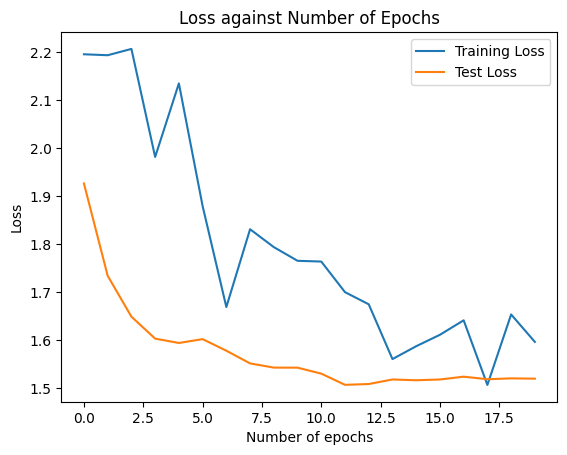

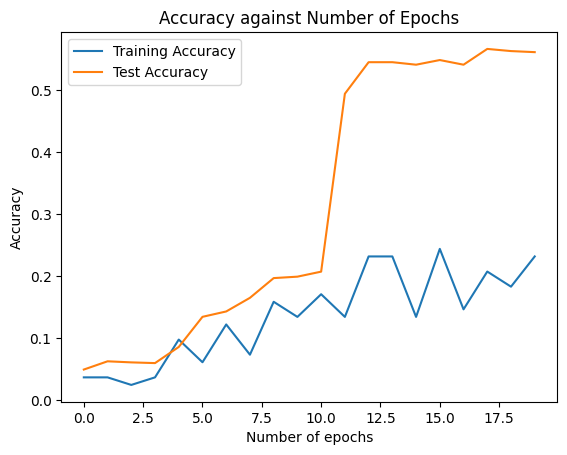

Test Loss: 1.5073. Accuracy of the network on the 1728 Test images: 49.4213 %,
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.00      0.00      0.00       126
           2       0.36      0.16      0.22       412
           3       0.04      0.14      0.07        95
           4       0.62      0.73      0.67      1059

    accuracy                           0.49      1728
   macro avg       0.21      0.21      0.19      1728
weighted avg       0.47      0.49      0.47      1728



C:\Users\kan_h\.conda\envs\cs5242_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kan_h\.conda\envs\cs5242_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kan_h\.conda\envs\cs5242_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
AddInfoClassifier_1.train_model()
AddInfoClassifier_1.plot_loss()
AddInfoClassifier_1.plot_acc()
AddInfoClassifier_1.save_best_model()
AddInfoClassifier_1.classification_result()

In [36]:
# del AddInfoClassifier_1
# gc.collect()
# torch.cuda.empty_cache()

#### Additional Info - WBC10

Epoch: 1 	Training Loss: 0.247078
Test Loss: 0.2472. On network with 16 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.243734
Test Loss: 0.2467. On network with 16 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.241943
Test Loss: 0.2467. On network with 16 Test images
Epoch: 4 	Training Loss: 0.246398
Test Loss: 0.2459. On network with 16 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.252650
Test Loss: 0.2456. On network with 16 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.238107
Test Loss: 0.2449. On network with 16 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.242989
Test Loss: 0.2440. On network with 16 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.231859
Test Loss: 0.2445. On network with 16 Test images
Epoch: 9 	Training Loss: 0.229172
Test Loss: 0.2410. On network with 16 Test images
Saving state on Epoch 9
Epoch: 10 	Training Loss: 0.242902
Test Loss: 0.2400. On network with 16 Tes

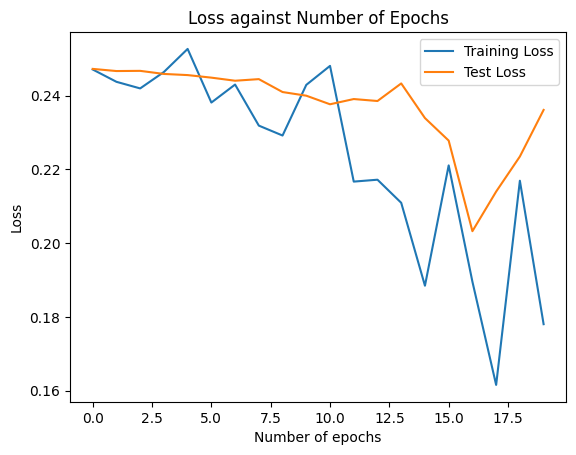

In [20]:
wbc_seg_10 = WBCSegmentation("WBC10_seg", r"../cs5242_project_dataset/WBC_10/train/mask/*/")
wbc_seg_10.train_model()
wbc_seg_10.plot_loss()
wbc_seg_10.save_best_model()

Epoch: 1 	Training Loss: 0.998690
Test Loss: 0.9843. On network with 151 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.944954
Test Loss: 0.9709. On network with 151 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.904529
Test Loss: 0.8829. On network with 151 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.785107
Test Loss: 0.6953. On network with 151 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.620803
Test Loss: 0.6192. On network with 151 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.578837
Test Loss: 0.5889. On network with 151 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.562733
Test Loss: 0.5810. On network with 151 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.556169
Test Loss: 0.5630. On network with 151 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.544482
Test Loss: 0.5603. On network with 151 Test images
Saving state on Epoch 9
Epoch: 10 	Training

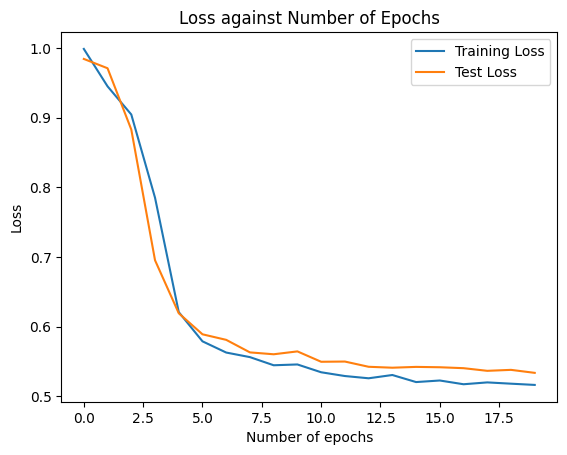

In [21]:
cam16_ae_10 = AutoEncoderTrainer("cam16_ae_10", r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data")

cam16_ae_10.set_model_state(wbc_seg_10.get_model_state())
cam16_ae_10.train_model()
cam16_ae_10.plot_loss()
cam16_ae_10.save_best_model()

Epoch: 1 	Training Loss: 0.683899
Test Loss: 0.6973. On network with 283 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.673162
Test Loss: 0.6871. On network with 283 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.669197
Test Loss: 0.6856. On network with 283 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.665255
Test Loss: 0.6827. On network with 283 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.667604
Test Loss: 0.6965. On network with 283 Test images
Epoch: 6 	Training Loss: 0.665883
Test Loss: 0.6823. On network with 283 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.662967
Test Loss: 0.6798. On network with 283 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.661558
Test Loss: 0.6917. On network with 283 Test images
Epoch: 9 	Training Loss: 0.663157
Test Loss: 0.6787. On network with 283 Test images
Saving state on Epoch 9
Epoch: 10 	Training Loss: 0.660003
Test Loss: 0.6760. On network wi

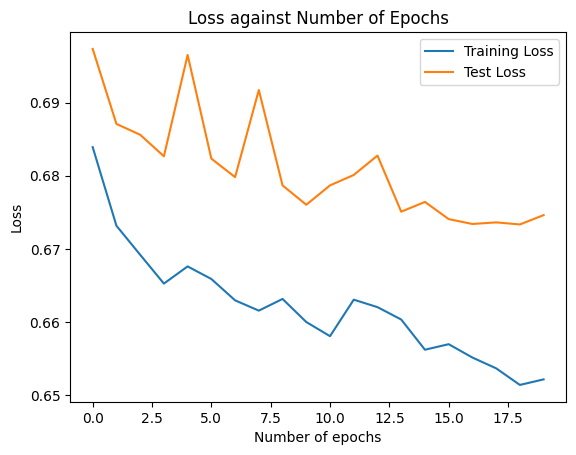

In [22]:
cam16_ae_10_state = cam16_ae_10.get_model_state()
del cam16_ae_10
gc.collect()
torch.cuda.empty_cache()
prcc_ae_10 = AutoEncoderTrainer("prcc_ae_10", r"../cs5242_project_dataset/pRCC_nolabel/")
prcc_ae_10.set_model_state(cam16_ae_10_state)
prcc_ae_10.train_model()
prcc_ae_10.plot_loss()
prcc_ae_10.save_best_model()

Epoch: 1 	Training Loss: 0.417009
Test Loss: 0.4106. On network with 168 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.387340
Test Loss: 0.3899. On network with 168 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.371865
Test Loss: 0.3761. On network with 168 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.361405
Test Loss: 0.3713. On network with 168 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.353090
Test Loss: 0.3598. On network with 168 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.343836
Test Loss: 0.3571. On network with 168 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.338021
Test Loss: 0.3634. On network with 168 Test images
Epoch: 8 	Training Loss: 0.334739
Test Loss: 0.3547. On network with 168 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.325722
Test Loss: 0.3548. On network with 168 Test images
Epoch: 10 	Training Loss: 0.321651
Test Loss: 0.3577. On network wi

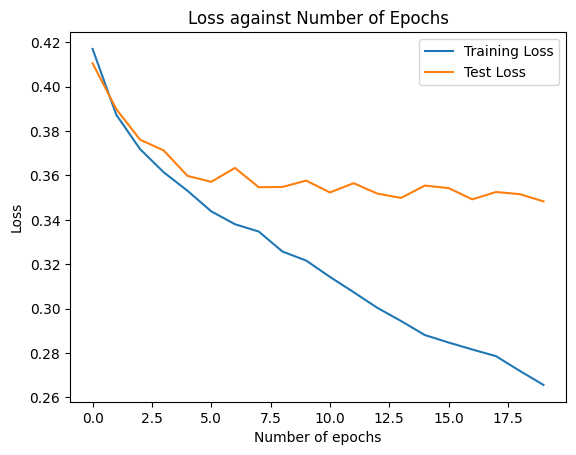

In [23]:
prcc_ae_10_state = prcc_ae_10.get_model_state()
del prcc_ae_10
gc.collect()
torch.cuda.empty_cache()
wbc_ae_10 = AutoEncoderTrainer("wbc_ae_10", r"../cs5242_project_dataset/WBC_10/train/data")
wbc_ae_10.set_model_state(prcc_ae_10_state)
wbc_ae_10.train_model()
wbc_ae_10.plot_loss()
wbc_ae_10.save_best_model()

Epoch [1/20], Loss: 0.6866, Train Accuracy: 63.2761 %
Test Loss: 0.6824. Accuracy of the network on the 108 Test images: 61.1111 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 0.6648, Train Accuracy: 68.2959 %
Test Loss: 0.6574. Accuracy of the network on the 108 Test images: 61.1111 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 0.6064, Train Accuracy: 70.6737 %
Test Loss: 0.5748. Accuracy of the network on the 108 Test images: 71.2963 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 0.4286, Train Accuracy: 82.9590 %
Test Loss: 0.6243. Accuracy of the network on the 108 Test images: 76.8519 %,
Epoch [5/20], Loss: 0.3361, Train Accuracy: 86.3937 %
Test Loss: 0.4171. Accuracy of the network on the 108 Test images: 83.3333 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 0.3099, Train Accuracy: 87.4505 %
Test Loss: 0.3929. Accuracy of the network on the 108 Test images: 83.3333 %,
Saving state on Epoch 6
Epoch [7/20], Loss: 0.2998, Train Accuracy: 87.7147 %
Test Loss: 0.3914. Accuracy of the

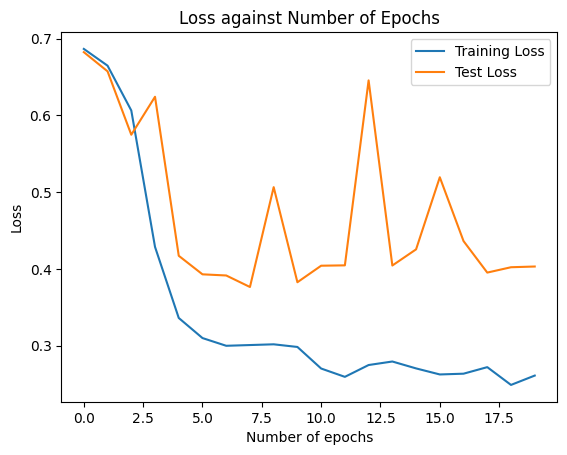

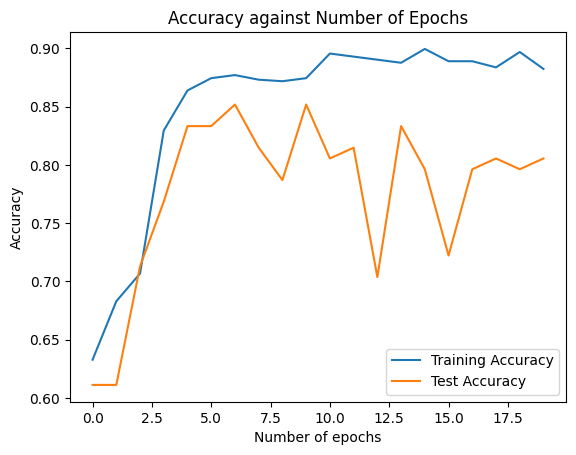

In [24]:
state = wbc_ae_10.get_model_state()
del wbc_ae_10
gc.collect()
torch.cuda.empty_cache()
CAM16Classifier_10 = CAM16Classifier(model_name='cam_10', 
                                    train_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data",
                                   test_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/val/data")
modified_state = create_classifier_state_from_autoencoder(state,2).state_dict()
CAM16Classifier_10.set_model_state(modified_state)
CAM16Classifier_10.freeze_layers(6)
CAM16Classifier_10.train_model()
CAM16Classifier_10.plot_loss()
CAM16Classifier_10.plot_acc()
CAM16Classifier_10.save_best_model()

In [25]:
AddInfoClassifier_10 = AddInfoClassifier(model_name='add_info_classifier_10', 
                                    train_path = r"../cs5242_project_dataset/WBC_10/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [26]:
CAM16Classifier_10_state = CAM16Classifier_10.get_model_state()
del CAM16Classifier_10
gc.collect()
torch.cuda.empty_cache()

CAM16Classifier_10_new_checkpoint = {}
for key, value in CAM16Classifier_10_state.items():
    if 'classifier.L3' not in key:
        CAM16Classifier_10_new_checkpoint[key] = value
        
AddInfoClassifier_10.set_model_state(CAM16Classifier_10_new_checkpoint)
AddInfoClassifier_10.freeze_layers(6)

Epoch [1/20], Loss: 1.6680, Train Accuracy: 45.4869 %
Test Loss: 1.4967. Accuracy of the network on the 1728 Test images: 61.1111 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.6494, Train Accuracy: 46.5558 %
Test Loss: 1.4996. Accuracy of the network on the 1728 Test images: 61.3426 %,
Epoch [3/20], Loss: 1.6047, Train Accuracy: 38.5986 %
Test Loss: 1.5582. Accuracy of the network on the 1728 Test images: 54.9769 %,
Epoch [4/20], Loss: 1.5771, Train Accuracy: 32.0665 %
Test Loss: 1.4910. Accuracy of the network on the 1728 Test images: 28.5301 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 1.5422, Train Accuracy: 32.0665 %
Test Loss: 1.3477. Accuracy of the network on the 1728 Test images: 27.2569 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 1.4860, Train Accuracy: 25.8907 %
Test Loss: 1.7004. Accuracy of the network on the 1728 Test images: 24.5370 %,
Epoch [7/20], Loss: 1.4679, Train Accuracy: 28.1473 %
Test Loss: 1.3139. Accuracy of the network on the 1728 Test images: 25.4630 

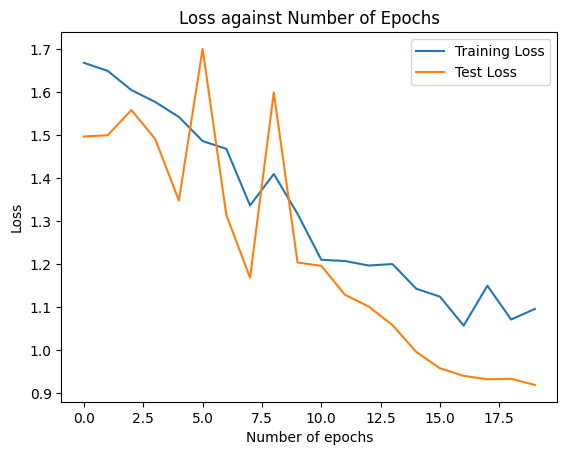

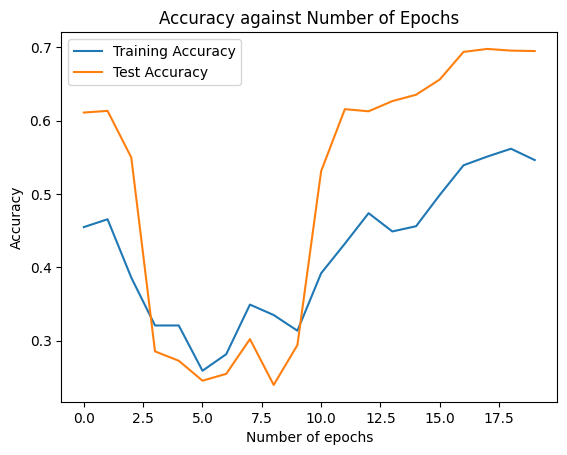

Test Loss: 0.9185. Accuracy of the network on the 1728 Test images: 69.5023 %,
              precision    recall  f1-score   support

           0       0.56      0.25      0.35        36
           1       0.26      0.16      0.20       126
           2       0.58      0.85      0.69       412
           3       0.37      0.45      0.41        95
           4       0.85      0.74      0.79      1059

    accuracy                           0.70      1728
   macro avg       0.53      0.49      0.49      1728
weighted avg       0.71      0.70      0.69      1728



In [27]:
AddInfoClassifier_10.train_model()
AddInfoClassifier_10.plot_loss()
AddInfoClassifier_10.plot_acc()
AddInfoClassifier_10.save_best_model()
AddInfoClassifier_10.classification_result()

In [28]:
del AddInfoClassifier_10
gc.collect()
torch.cuda.empty_cache()

#### Additional Info - WBC50

Epoch: 1 	Training Loss: 0.243214
Test Loss: 0.2453. On network with 83 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.208435
Test Loss: 0.2347. On network with 83 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.177964
Test Loss: 0.1944. On network with 83 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.150854
Test Loss: 0.1504. On network with 83 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.144991
Test Loss: 0.1530. On network with 83 Test images
Epoch: 6 	Training Loss: 0.130857
Test Loss: 0.1323. On network with 83 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.122281
Test Loss: 0.1252. On network with 83 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.120513
Test Loss: 0.1357. On network with 83 Test images
Epoch: 9 	Training Loss: 0.110978
Test Loss: 0.1029. On network with 83 Test images
Saving state on Epoch 9
Epoch: 10 	Training Loss: 0.085307
Test Loss: 0.0880. On network with 83 Tes

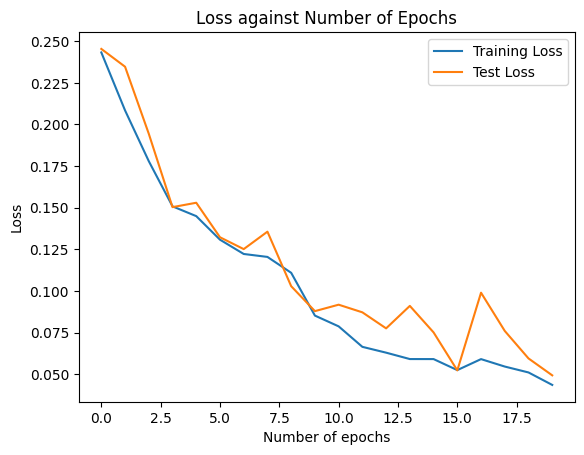

In [20]:
wbc_seg_50 = WBCSegmentation("WBC50_seg", r"../cs5242_project_dataset/WBC_50/train/mask/*/")
wbc_seg_50.train_model()
wbc_seg_50.plot_loss()
wbc_seg_50.save_best_model()

Epoch: 1 	Training Loss: 1.004364
Test Loss: 0.8730. On network with 151 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.730047
Test Loss: 0.8062. On network with 151 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.651420
Test Loss: 0.6965. On network with 151 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.610194
Test Loss: 0.6441. On network with 151 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.584797
Test Loss: 0.6209. On network with 151 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.568536
Test Loss: 0.6093. On network with 151 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.558826
Test Loss: 0.6021. On network with 151 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.554035
Test Loss: 0.5887. On network with 151 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.544377
Test Loss: 0.5842. On network with 151 Test images
Saving state on Epoch 9
Epoch: 10 	Training

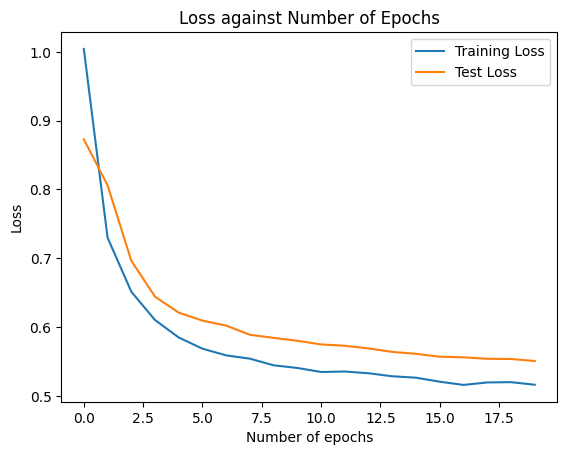

In [21]:
cam16_ae_50 = AutoEncoderTrainer("cam16_ae_50", r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data")

cam16_ae_50.set_model_state(wbc_seg_50.get_model_state())
cam16_ae_50.train_model()
cam16_ae_50.plot_loss()
cam16_ae_50.save_best_model()

Epoch: 1 	Training Loss: 0.683064
Test Loss: 0.6899. On network with 283 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.672147
Test Loss: 0.6820. On network with 283 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.667109
Test Loss: 0.6817. On network with 283 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.666129
Test Loss: 0.6823. On network with 283 Test images
Epoch: 5 	Training Loss: 0.663867
Test Loss: 0.6789. On network with 283 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.662250
Test Loss: 0.6784. On network with 283 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.662084
Test Loss: 0.6808. On network with 283 Test images
Epoch: 8 	Training Loss: 0.660657
Test Loss: 0.6806. On network with 283 Test images
Epoch: 9 	Training Loss: 0.662442
Test Loss: 0.6807. On network with 283 Test images
Epoch: 10 	Training Loss: 0.663851
Test Loss: 0.6798. On network with 283 Test images
Epoch: 11 	Training Loss: 0.6

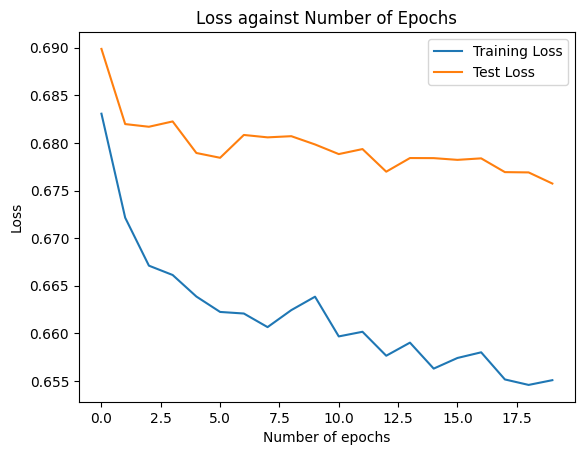

In [22]:
cam16_ae_50_state = cam16_ae_50.get_model_state()
del cam16_ae_50
gc.collect()
torch.cuda.empty_cache()
prcc_ae_50 = AutoEncoderTrainer("prcc_ae_50", r"../cs5242_project_dataset/pRCC_nolabel/")
prcc_ae_50.set_model_state(cam16_ae_50_state)
prcc_ae_50.train_model()
prcc_ae_50.plot_loss()
prcc_ae_50.save_best_model()

Epoch: 1 	Training Loss: 0.382825
Test Loss: 0.3664. On network with 844 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.352798
Test Loss: 0.3591. On network with 844 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.337425
Test Loss: 0.3451. On network with 844 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.326487
Test Loss: 0.3385. On network with 844 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.315145
Test Loss: 0.3267. On network with 844 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.301815
Test Loss: 0.3158. On network with 844 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.290881
Test Loss: 0.3082. On network with 844 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.282379
Test Loss: 0.3008. On network with 844 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.272761
Test Loss: 0.2862. On network with 844 Test images
Saving state on Epoch 9
Epoch: 10 	Training

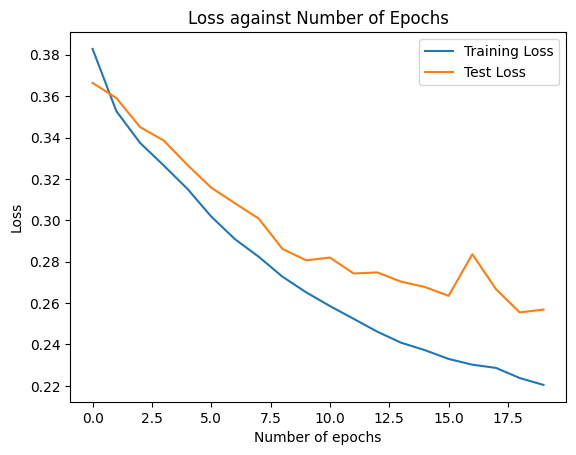

In [23]:
prcc_ae_50_state = prcc_ae_50.get_model_state()
del prcc_ae_50
gc.collect()
torch.cuda.empty_cache()
wbc_ae_50 = AutoEncoderTrainer("wbc_ae_50", r"../cs5242_project_dataset/WBC_50/train/data")
wbc_ae_50.set_model_state(prcc_ae_50_state)
wbc_ae_50.train_model()
wbc_ae_50.plot_loss()
wbc_ae_50.save_best_model()

Epoch [1/20], Loss: 0.6957, Train Accuracy: 49.9339 %
Test Loss: 0.6833. Accuracy of the network on the 108 Test images: 50.0000 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 0.6901, Train Accuracy: 50.0661 %
Test Loss: 0.6788. Accuracy of the network on the 108 Test images: 52.7778 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 0.6690, Train Accuracy: 69.6169 %
Test Loss: 0.6416. Accuracy of the network on the 108 Test images: 74.0741 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 0.5626, Train Accuracy: 77.1466 %
Test Loss: 0.5854. Accuracy of the network on the 108 Test images: 77.7778 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 0.4109, Train Accuracy: 83.0911 %
Test Loss: 0.4677. Accuracy of the network on the 108 Test images: 82.4074 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 0.3623, Train Accuracy: 83.8838 %
Test Loss: 0.5343. Accuracy of the network on the 108 Test images: 79.6296 %,
Epoch [7/20], Loss: 0.3472, Train Accuracy: 84.8085 %
Test Loss: 0.4447. Accuracy of the

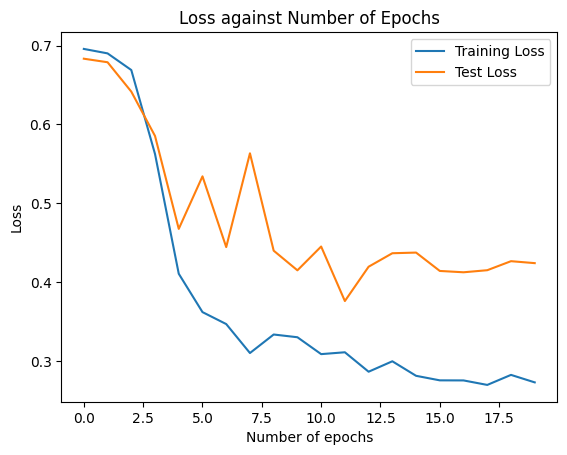

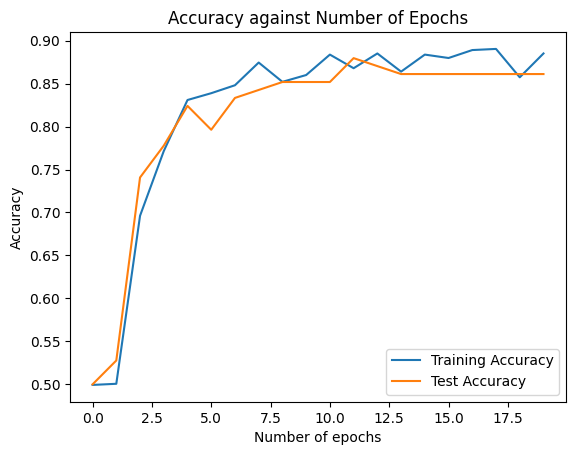

In [24]:
state = wbc_ae_50.get_model_state()
del wbc_ae_50
gc.collect()
torch.cuda.empty_cache()
CAM16Classifier_50 = CAM16Classifier(model_name='cam_50', 
                                    train_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data",
                                   test_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/val/data")
modified_state = create_classifier_state_from_autoencoder(state,2).state_dict()
CAM16Classifier_50.set_model_state(modified_state)
CAM16Classifier_50.freeze_layers(6)
CAM16Classifier_50.train_model()
CAM16Classifier_50.plot_loss()
CAM16Classifier_50.plot_acc()
CAM16Classifier_50.save_best_model()

In [25]:
AddInfoClassifier_50 = AddInfoClassifier(model_name='add_info_classifier_50', 
                                    train_path = r"../cs5242_project_dataset/WBC_50/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [26]:
CAM16Classifier_50_state = CAM16Classifier_50.get_model_state()
del CAM16Classifier_50
gc.collect()
torch.cuda.empty_cache()

CAM16Classifier_50_new_checkpoint = {}
for key, value in CAM16Classifier_50_state.items():
    if 'classifier.L3' not in key:
        CAM16Classifier_50_new_checkpoint[key] = value
        
AddInfoClassifier_50.set_model_state(CAM16Classifier_50_new_checkpoint)
AddInfoClassifier_50.freeze_layers(6)

Epoch [1/20], Loss: 1.6681, Train Accuracy: 16.7180 %
Test Loss: 1.5982. Accuracy of the network on the 1728 Test images: 5.4977 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.6113, Train Accuracy: 10.6559 %
Test Loss: 1.7085. Accuracy of the network on the 1728 Test images: 4.7454 %,
Epoch [3/20], Loss: 1.5868, Train Accuracy: 10.2297 %
Test Loss: 1.6423. Accuracy of the network on the 1728 Test images: 22.6852 %,
Epoch [4/20], Loss: 1.4873, Train Accuracy: 22.2354 %
Test Loss: 1.4977. Accuracy of the network on the 1728 Test images: 29.9769 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 1.3018, Train Accuracy: 39.8532 %
Test Loss: 1.0261. Accuracy of the network on the 1728 Test images: 42.7662 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 1.1129, Train Accuracy: 61.0703 %
Test Loss: 0.5450. Accuracy of the network on the 1728 Test images: 81.8287 %,
Saving state on Epoch 6
Epoch [7/20], Loss: 0.9225, Train Accuracy: 72.3656 %
Test Loss: 0.4850. Accuracy of the network on the 1728

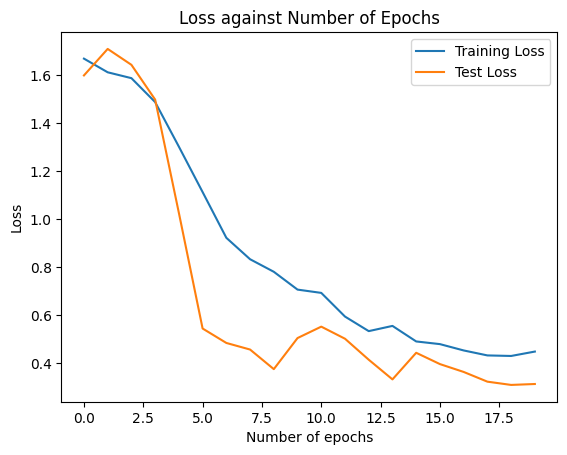

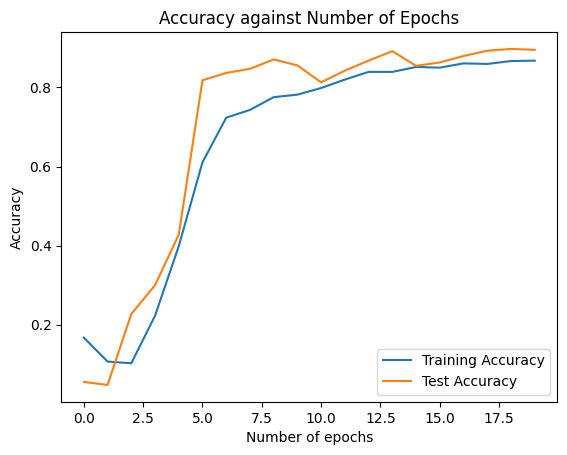

Test Loss: 0.3103. Accuracy of the network on the 1728 Test images: 89.7569 %,
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        36
           1       0.56      0.77      0.65       126
           2       0.92      0.91      0.92       412
           3       0.72      0.41      0.52        95
           4       0.96      0.95      0.96      1059

    accuracy                           0.90      1728
   macro avg       0.78      0.78      0.77      1728
weighted avg       0.90      0.90      0.90      1728



In [27]:
AddInfoClassifier_50.train_model()
AddInfoClassifier_50.plot_loss()
AddInfoClassifier_50.plot_acc()
AddInfoClassifier_50.save_best_model()
AddInfoClassifier_50.classification_result()

#### Additional Info - WBC100

Epoch: 1 	Training Loss: 0.231836
Test Loss: 0.2423. On network with 168 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.163873
Test Loss: 0.1759. On network with 168 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.132991
Test Loss: 0.1265. On network with 168 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.120821
Test Loss: 0.1195. On network with 168 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.098701
Test Loss: 0.0828. On network with 168 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.066320
Test Loss: 0.0695. On network with 168 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.066491
Test Loss: 0.0680. On network with 168 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.056170
Test Loss: 0.0543. On network with 168 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.050821
Test Loss: 0.0558. On network with 168 Test images
Epoch: 10 	Training Loss: 0.052214
Test Los

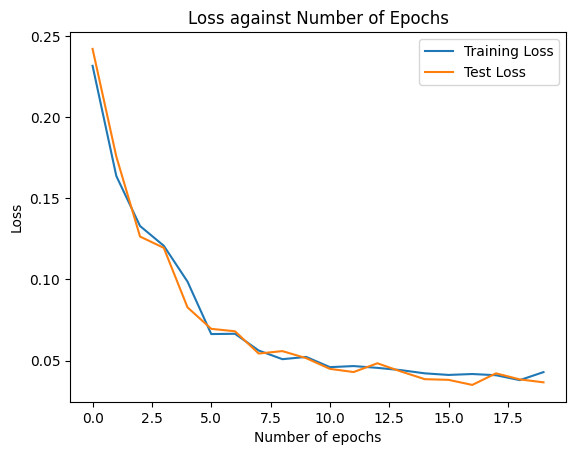

In [14]:
wbc_seg_100 = WBCSegmentation("WBC100_seg", r"../cs5242_project_dataset/WBC_100/train/mask/*/")
wbc_seg_100.train_model()
wbc_seg_100.plot_loss()
wbc_seg_100.save_best_model()

Epoch: 1 	Training Loss: 1.090411
Test Loss: 0.8723. On network with 151 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.742819
Test Loss: 0.7418. On network with 151 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.682423
Test Loss: 0.6770. On network with 151 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.639586
Test Loss: 0.6307. On network with 151 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.607775
Test Loss: 0.6050. On network with 151 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.591866
Test Loss: 0.5885. On network with 151 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.580889
Test Loss: 0.5769. On network with 151 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.571821
Test Loss: 0.5873. On network with 151 Test images
Epoch: 9 	Training Loss: 0.561207
Test Loss: 0.5667. On network with 151 Test images
Saving state on Epoch 9
Epoch: 10 	Training Loss: 0.548806
Test Los

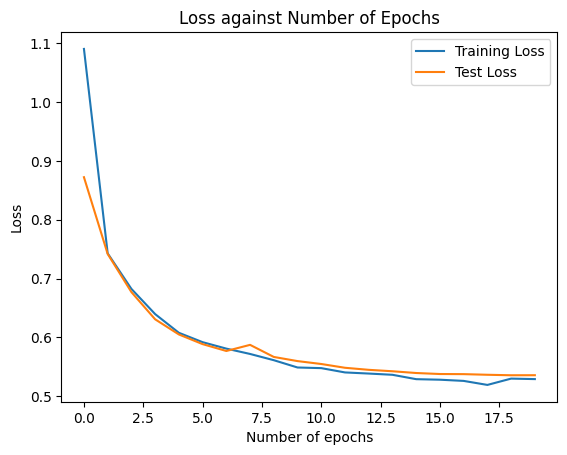

In [15]:
cam16_ae_100 = AutoEncoderTrainer("cam16_ae_100", r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data")

cam16_ae_100.set_model_state(wbc_seg_100.get_model_state())
cam16_ae_100.train_model()
cam16_ae_100.plot_loss()
cam16_ae_100.save_best_model()

Epoch: 1 	Training Loss: 0.688053
Test Loss: 0.6853. On network with 283 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.676016
Test Loss: 0.6710. On network with 283 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.671892
Test Loss: 0.6686. On network with 283 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.668770
Test Loss: 0.6670. On network with 283 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.667001
Test Loss: 0.6655. On network with 283 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.667700
Test Loss: 0.6727. On network with 283 Test images
Epoch: 7 	Training Loss: 0.665528
Test Loss: 0.6659. On network with 283 Test images
Epoch: 8 	Training Loss: 0.663614
Test Loss: 0.6627. On network with 283 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.662378
Test Loss: 0.6639. On network with 283 Test images
Epoch: 10 	Training Loss: 0.662873
Test Loss: 0.6647. On network with 283 Test images
Epoch

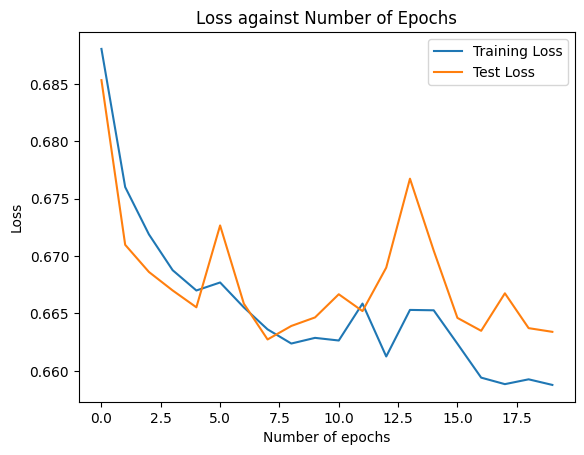

In [16]:
cam16_ae_100_state = cam16_ae_100.get_model_state()
del cam16_ae_100
gc.collect()
torch.cuda.empty_cache()
prcc_ae_100 = AutoEncoderTrainer("prcc_ae_100", r"../cs5242_project_dataset/pRCC_nolabel/")
prcc_ae_100.set_model_state(cam16_ae_100_state)
prcc_ae_100.train_model()
prcc_ae_100.plot_loss()
prcc_ae_100.save_best_model()

Epoch: 1 	Training Loss: 0.389181
Test Loss: 0.3736. On network with 1689 Test images
Saving state on Epoch 1
Epoch: 2 	Training Loss: 0.358080
Test Loss: 0.3531. On network with 1689 Test images
Saving state on Epoch 2
Epoch: 3 	Training Loss: 0.338488
Test Loss: 0.3324. On network with 1689 Test images
Saving state on Epoch 3
Epoch: 4 	Training Loss: 0.322061
Test Loss: 0.3264. On network with 1689 Test images
Saving state on Epoch 4
Epoch: 5 	Training Loss: 0.302658
Test Loss: 0.3051. On network with 1689 Test images
Saving state on Epoch 5
Epoch: 6 	Training Loss: 0.287790
Test Loss: 0.2942. On network with 1689 Test images
Saving state on Epoch 6
Epoch: 7 	Training Loss: 0.274863
Test Loss: 0.2793. On network with 1689 Test images
Saving state on Epoch 7
Epoch: 8 	Training Loss: 0.264239
Test Loss: 0.2764. On network with 1689 Test images
Saving state on Epoch 8
Epoch: 9 	Training Loss: 0.255793
Test Loss: 0.2752. On network with 1689 Test images
Saving state on Epoch 9
Epoch: 10 

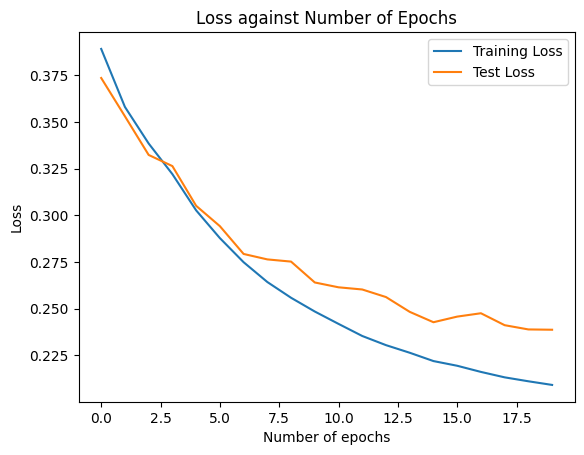

In [19]:
# prcc_ae_100_state = prcc_ae_100.get_model_state()
# del prcc_ae_100
gc.collect()
torch.cuda.empty_cache()
wbc_ae_100 = AutoEncoderTrainer("wbc_ae_100", r"../cs5242_project_dataset/WBC_100/train/data")
wbc_ae_100.set_model_state(prcc_ae_100_state)
wbc_ae_100.train_model()
wbc_ae_100.plot_loss()
wbc_ae_100.save_best_model()

Epoch [1/20], Loss: 0.6935, Train Accuracy: 49.9339 %
Test Loss: 0.6835. Accuracy of the network on the 108 Test images: 50.0000 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 0.6854, Train Accuracy: 61.8230 %
Test Loss: 0.6759. Accuracy of the network on the 108 Test images: 71.2963 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 0.6500, Train Accuracy: 76.0898 %
Test Loss: 0.6023. Accuracy of the network on the 108 Test images: 75.9259 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 0.5050, Train Accuracy: 79.9207 %
Test Loss: 0.5242. Accuracy of the network on the 108 Test images: 77.7778 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 0.3852, Train Accuracy: 82.6948 %
Test Loss: 0.5940. Accuracy of the network on the 108 Test images: 79.6296 %,
Epoch [6/20], Loss: 0.3742, Train Accuracy: 84.1480 %
Test Loss: 0.4343. Accuracy of the network on the 108 Test images: 78.7037 %,
Saving state on Epoch 6
Epoch [7/20], Loss: 0.3310, Train Accuracy: 84.6764 %
Test Loss: 0.4366. Accuracy of the

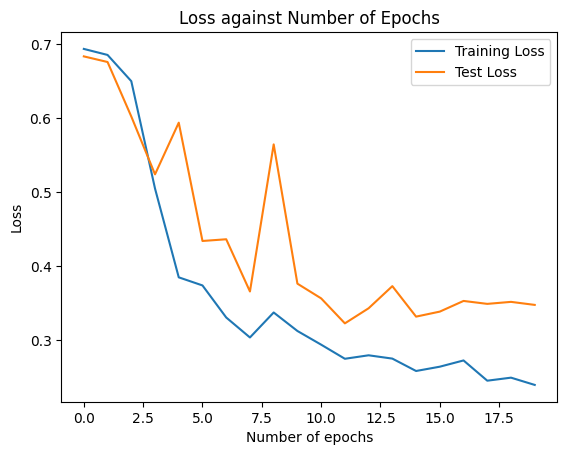

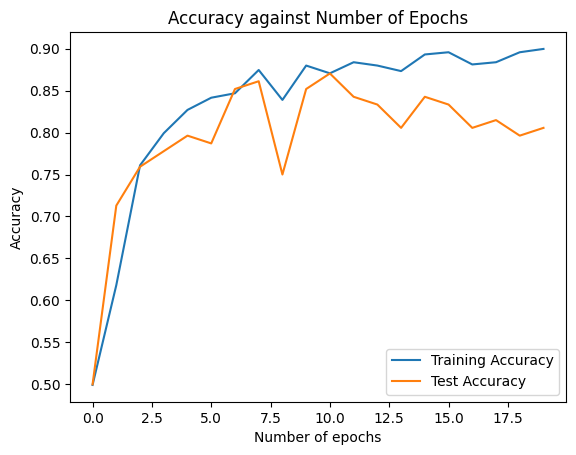

In [20]:
state = wbc_ae_100.get_model_state()
del wbc_ae_100
gc.collect()
torch.cuda.empty_cache()
CAM16Classifier_100 = CAM16Classifier(model_name='cam_100', 
                                    train_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/train/data",
                                   test_path = r"../cs5242_project_dataset/CAM16_100cls_10mask/val/data")
modified_state = create_classifier_state_from_autoencoder(state,2).state_dict()
CAM16Classifier_100.set_model_state(modified_state)
CAM16Classifier_100.freeze_layers(6)
CAM16Classifier_100.train_model()
CAM16Classifier_100.plot_loss()
CAM16Classifier_100.plot_acc()
CAM16Classifier_100.save_best_model()

In [21]:
AddInfoClassifier_100 = AddInfoClassifier(model_name='add_info_classifier_100', 
                                    train_path = r"../cs5242_project_dataset/WBC_100/train/data",
                                   test_path = r"../cs5242_project_dataset/WBC_100/val/data")

In [22]:
CAM16Classifier_100_state = CAM16Classifier_100.get_model_state()
del CAM16Classifier_100
gc.collect()
torch.cuda.empty_cache()

CAM16Classifier_100_new_checkpoint = {}
for key, value in CAM16Classifier_100_state.items():
    if 'classifier.L3' not in key:
        CAM16Classifier_100_new_checkpoint[key] = value
        
AddInfoClassifier_100.set_model_state(CAM16Classifier_100_new_checkpoint)
AddInfoClassifier_100.freeze_layers(6)

Epoch [1/20], Loss: 1.7085, Train Accuracy: 7.3636 %
Test Loss: 1.8592. Accuracy of the network on the 1728 Test images: 5.5556 %,
Saving state on Epoch 1
Epoch [2/20], Loss: 1.5765, Train Accuracy: 15.8636 %
Test Loss: 1.6106. Accuracy of the network on the 1728 Test images: 22.6273 %,
Saving state on Epoch 2
Epoch [3/20], Loss: 1.3577, Train Accuracy: 28.7558 %
Test Loss: 1.1971. Accuracy of the network on the 1728 Test images: 29.6875 %,
Saving state on Epoch 3
Epoch [4/20], Loss: 1.0586, Train Accuracy: 60.1989 %
Test Loss: 0.5713. Accuracy of the network on the 1728 Test images: 78.8773 %,
Saving state on Epoch 4
Epoch [5/20], Loss: 0.7756, Train Accuracy: 74.8313 %
Test Loss: 0.3717. Accuracy of the network on the 1728 Test images: 87.2106 %,
Saving state on Epoch 5
Epoch [6/20], Loss: 0.6600, Train Accuracy: 78.1461 %
Test Loss: 0.3832. Accuracy of the network on the 1728 Test images: 86.0532 %,
Epoch [7/20], Loss: 0.5934, Train Accuracy: 80.5375 %
Test Loss: 0.3291. Accuracy of

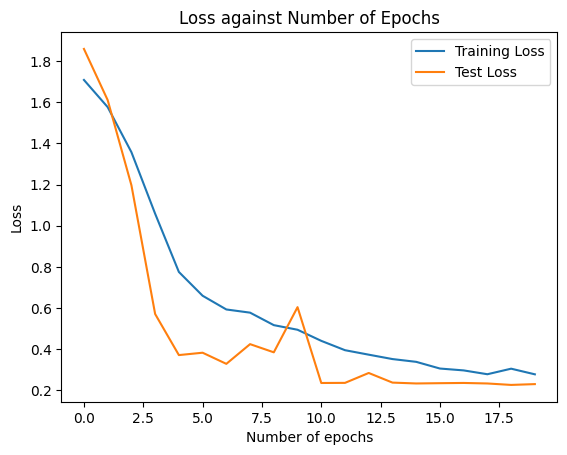

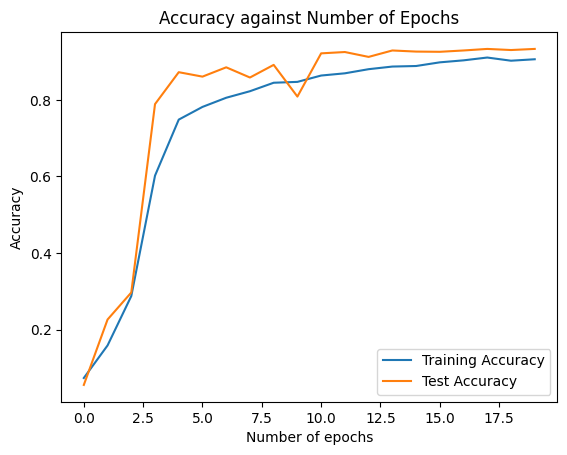

Test Loss: 0.2268. Accuracy of the network on the 1728 Test images: 92.9977 %,
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.70      0.80      0.75       126
           2       0.91      0.97      0.94       412
           3       0.82      0.57      0.67        95
           4       0.98      0.96      0.97      1059

    accuracy                           0.93      1728
   macro avg       0.87      0.84      0.85      1728
weighted avg       0.93      0.93      0.93      1728



In [23]:
AddInfoClassifier_100.train_model()
AddInfoClassifier_100.plot_loss()
AddInfoClassifier_100.plot_acc()
AddInfoClassifier_100.save_best_model()
AddInfoClassifier_100.classification_result()